## Customer Segmentation using Unsupervised Machine Learning Techniques

Objective: Grouping customers with similar behaviour into segments and understand their preferences. The techniques used here are K-means Clustering, Hierarchical Clustering, DBSCAN Clustering

### 1. Importing necessary libraries

In [38]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
from mpl_toolkits import mplot3d 
import missingno as msno 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from IPython.display import Markdown, display
from scipy.cluster.hierarchy import dendrogram, linkage 
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples

plt.style.use('seaborn-v0_8-darkgrid')
import warnings
warnings.filterwarnings('ignore') 

### 2. Dataset View

In [4]:
data = pd.read_excel('online_retail_II.xlsx') 
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### 3. Dataset features and count

In [5]:
print("Features : ",data.columns) 
print("# of rows : ",data.shape[0]) 
print("# of columns : ",data.shape[1])  

Features :  Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
# of rows :  525461
# of columns :  8


### 4. Dataset Information

In [6]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


### 5. Checking for Duplicates

In [7]:
data.duplicated().value_counts() 

False    518596
True       6865
Name: count, dtype: int64

`6865` duplicate values are present in the dataset

### 6. Checking for Missing Values

In [8]:
data.isna().sum() 

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

### **Overview of observations till now**

1. Dataset has 525461 observations with 8 features
2. Features, `Customer ID` and `Description` has null values
3. There are `6865` duplicate entries in the dataset

### 7. Understanding Features

In [9]:
data.columns 

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

1. Invoice : Unique 6 digit number to identify a transaction. If this number starts with 'c', it means cancellation

2. StockCode : 5 digit number that identifies a product 

3. Description : Product name

4. Quantity : Quantity of each product per transaction

5. InvoiceDate : Date and time at which transaction was done

6. Price : Product price per unit

7. Customer ID : 5 digit number to uniquely identify a customer

8. Country : Country where the customer is 

### 8. Checking unique values for each variable

In [10]:
for i in data.columns.tolist():
    print(f'# of unique values in {i} : {data[i].nunique()}')

# of unique values in Invoice : 28816
# of unique values in StockCode : 4632
# of unique values in Description : 4681
# of unique values in Quantity : 825
# of unique values in InvoiceDate : 25296
# of unique values in Price : 1606
# of unique values in Customer ID : 4383
# of unique values in Country : 40


### 9. Data cleaning and Feature engineering

#### 9.1 Dropping unnecessary columns

In [11]:
missing_values = (data.isna().sum()*100)/len(data) 
missing_df = pd.DataFrame({'Feature_name':data.columns,'missing_precentage':missing_values})
missing_df 

,Feature_name,missing_precentage
Invoice,Invoice,0.000000
StockCode,StockCode,0.000000
Description,Description,0.557225
Quantity,Quantity,0.000000
InvoiceDate,InvoiceDate,0.000000
Price,Price,0.000000
Customer ID,Customer ID,20.539488
Country,Country,0.000000


Around 20% of observations in dataset are not assignes with any customer. These data are not valuable to form clusters. So, rows where CustomerID is a null value is dropped

In [12]:
data.dropna(subset=['Customer ID'], inplace=True) 

#### 9.2 Dropping duplicate columns 

In [14]:
data.drop_duplicates(inplace=True) 

In [17]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']) 

data['Year'] = data['InvoiceDate'].apply(lambda x:x.year) 
data['Month'] = data['InvoiceDate'].dt.month_name()
data['Day'] = data['InvoiceDate'].dt.day_name()
data['Hour'] = data['InvoiceDate'].apply(lambda x:x.hour) 

In [18]:
data.head() 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,Day,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,December,Tuesday,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,December,Tuesday,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,December,Tuesday,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,December,Tuesday,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,December,Tuesday,7


#### 9.3 Creating Total amount feature 

In [19]:
data['Total_amount'] = data['Quantity']*data['Price']

#### 9.4 Creating Time type feature

In [20]:
data['Time_type'] = np.where((data['Hour']>5)&(data['Hour']<18),np.where(data['Hour']<12, 'Morning', 'Afternoon'), 'Evening')

#### 9.5 Extracting Cancellation Data

In [21]:
data['Invoice'] = data['Invoice'].astype('str') 
cancel_df = data[data['Invoice'].str.contains('C')]
cancel_df.shape 

(9816, 14)

#### 9.6 Dropping Cancelled data 

In [22]:
data = data[~data['Invoice'].str.contains('C')]

## 10. Exploratory Data Analysis

#### 10.1 Plotting highly frequent values in each column

In [30]:
target = ['StockCode', 'Description', 'Price', 'Customer ID',
 'Country', 'Year', 'Month', 'Day', 'Hour', 'Time_type']

In [31]:
data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Year', 'Month', 'Day', 'Hour',
       'Total_amount', 'Time_type'],
      dtype='object')

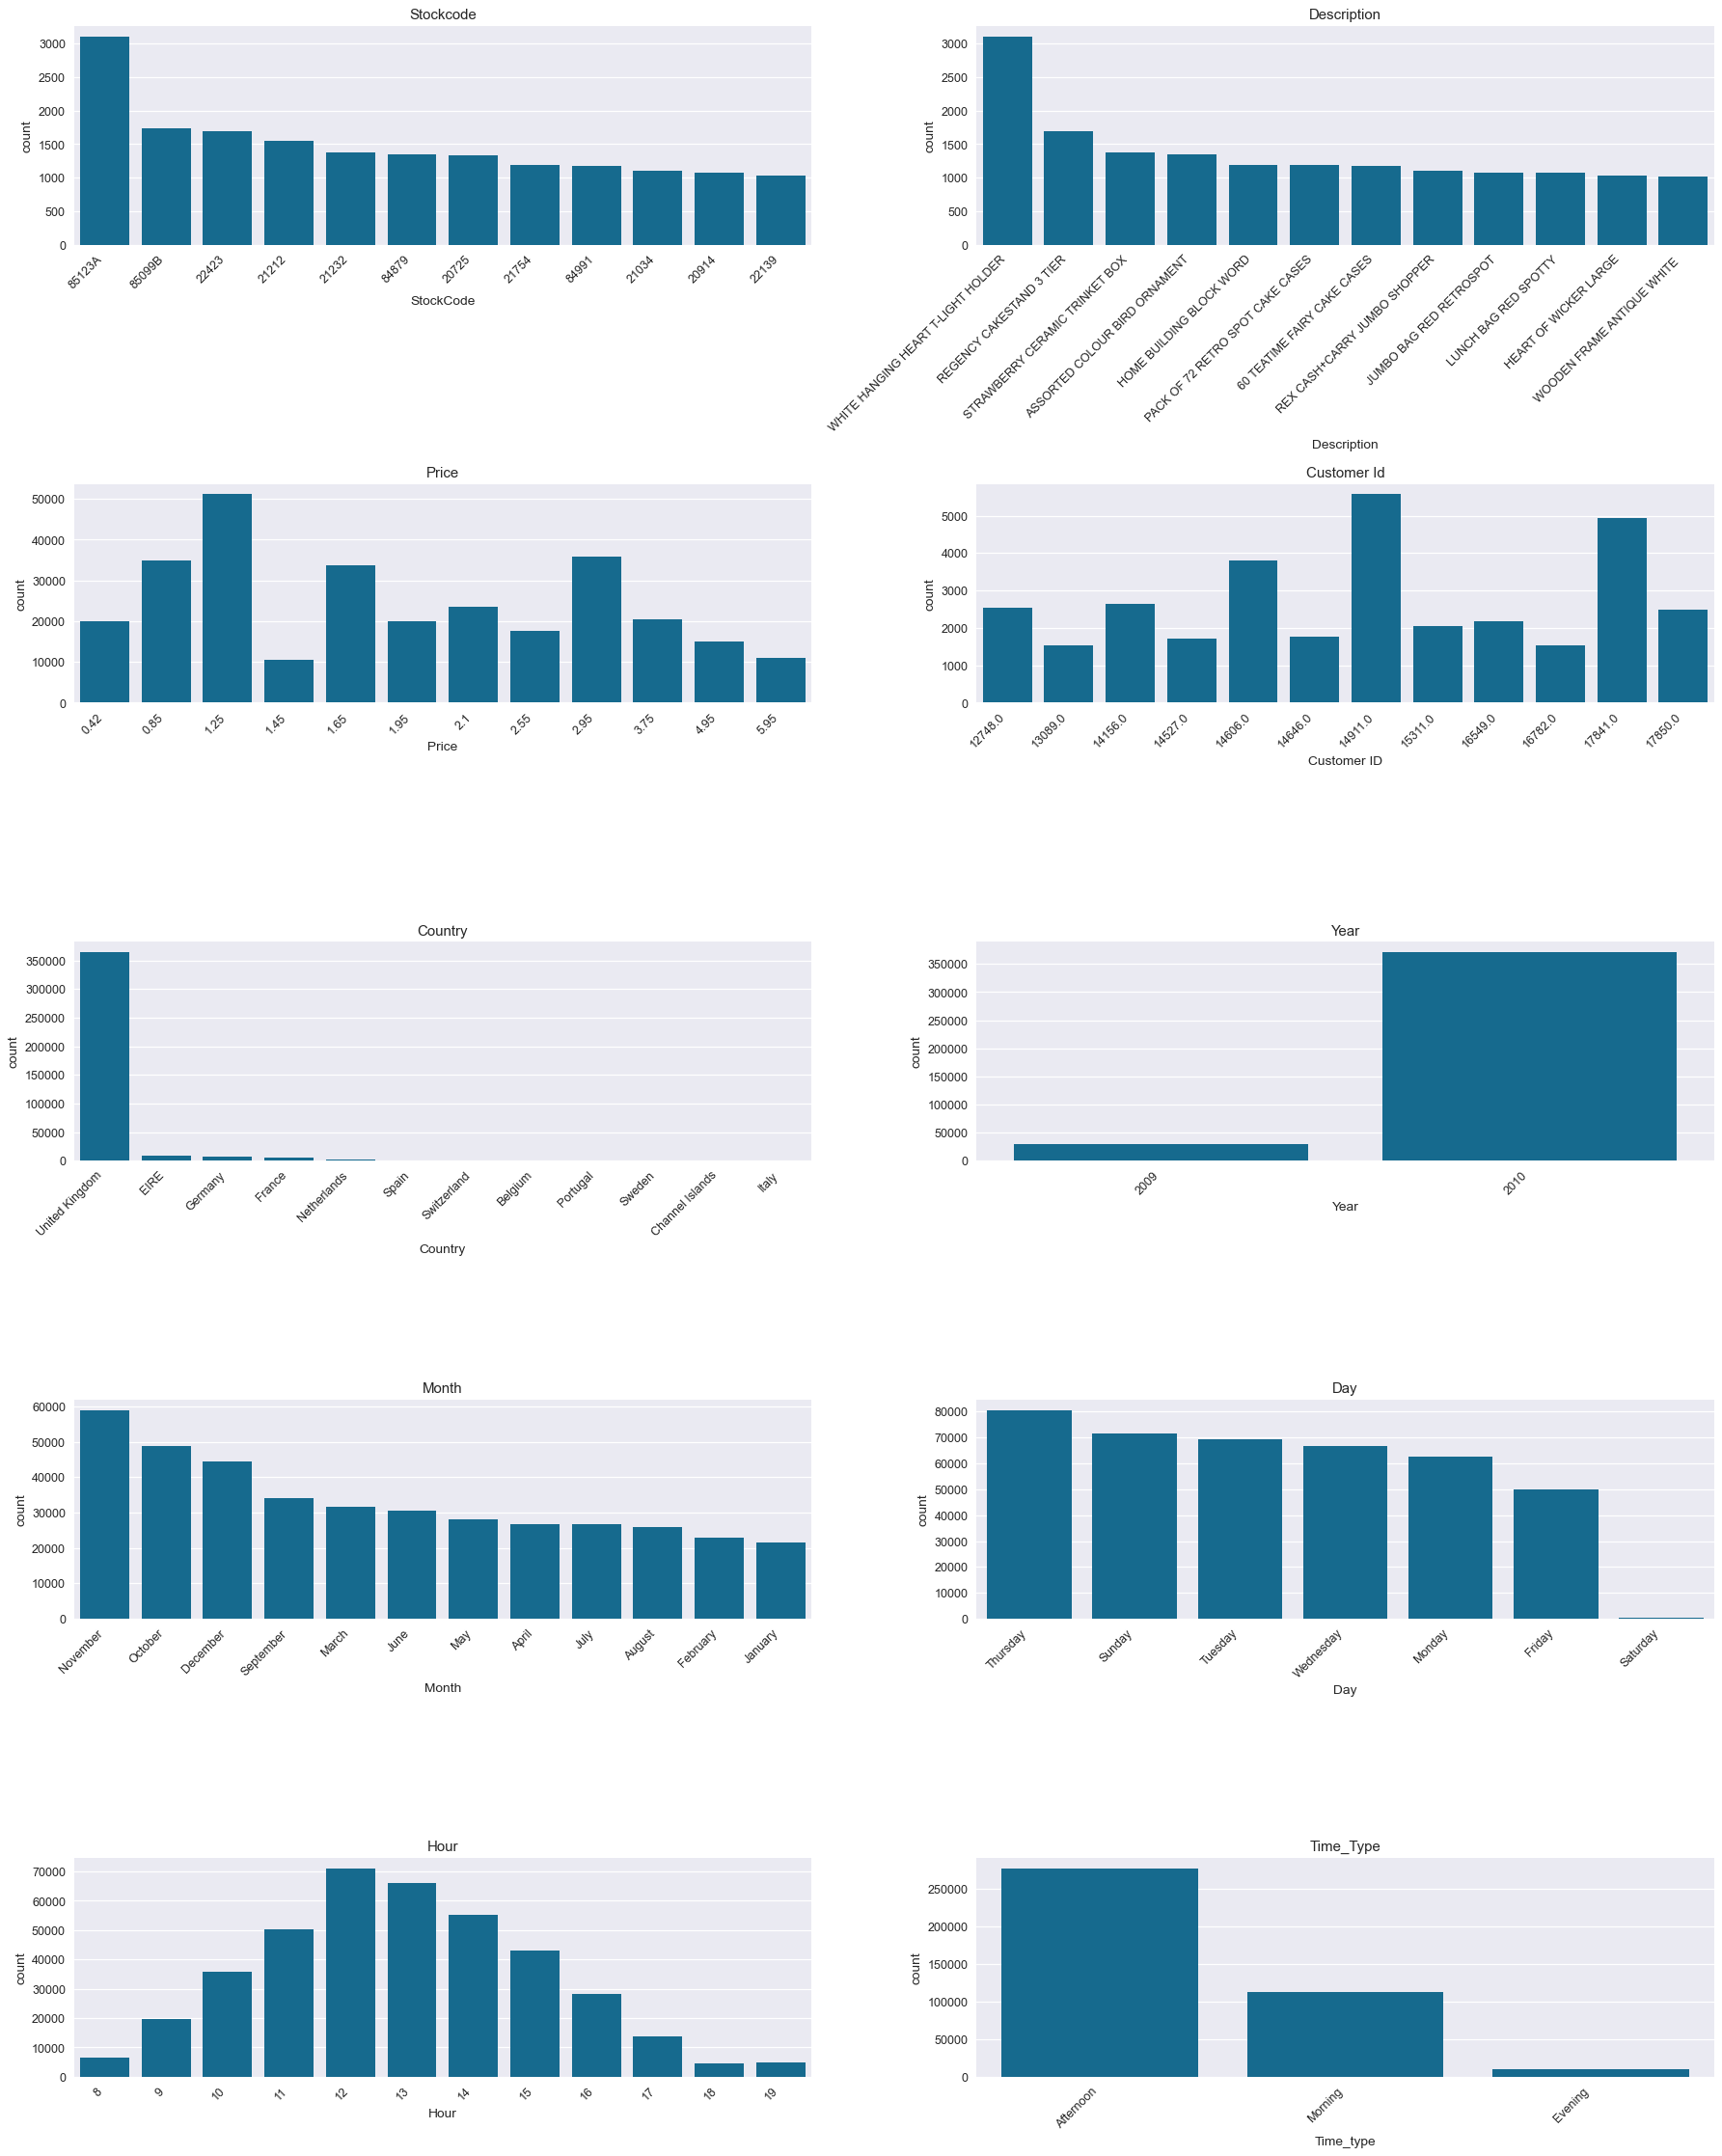

In [39]:
plt.figure(figsize=(20,25), dpi=90) 
for n,col in enumerate(target):
    plt.subplot(5, 2, n+1) 
    temp = data[col].value_counts().reset_index().head(12)
    sns.barplot(x=col, y='count', data=temp).set(title=col.title())
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout() 

#### 10.2 Plotting low frequent values in each column

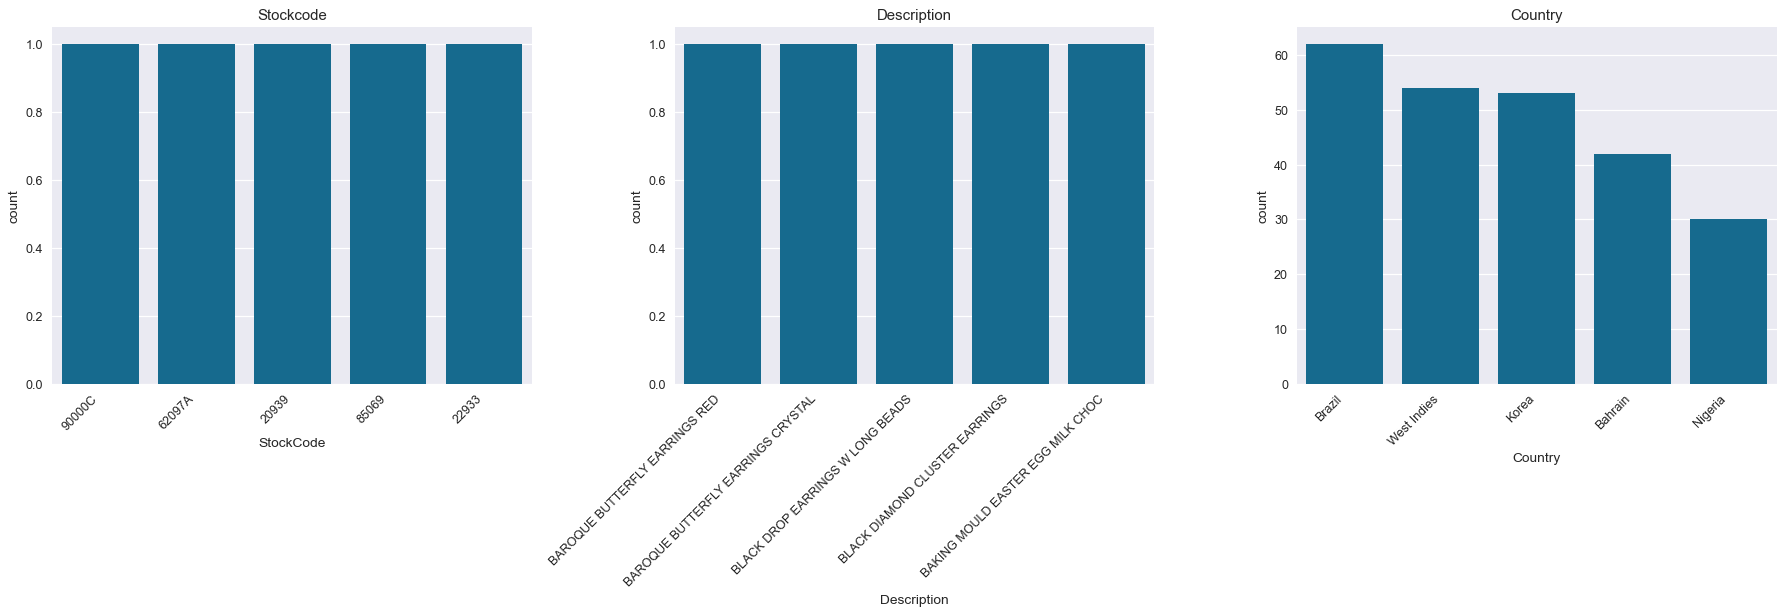

In [44]:
target2 = ['StockCode', 'Description', 'Country'] 

plt.figure(figsize=(20,7), dpi=90)
for n,col in enumerate(target2):
    plt.subplot(1, 3, n+1) 
    temp = data[col].value_counts().reset_index().tail(5)
    sns.barplot(x=col, y='count', data=temp).set(title=col.title())
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()  

### Overview of observations

1. Most Customers are from United Kingdom. Considerable amount only from France, Germany, EIRE and Netherlands. Italy is javing the least number of customers

2. There are least orders placed on Saturday. Showing that maybe it is a non-working day for the retailer

3. Most of the customers purchase gifts in the month of November, October, December and September

4. Most customers wish to purchase items in afternoon and least in the evening

5. The most ordered products are WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER, STRAWBERRY CERAMIC TRINKET BOX

#### 10.3 Visualizing Numeric Distributions

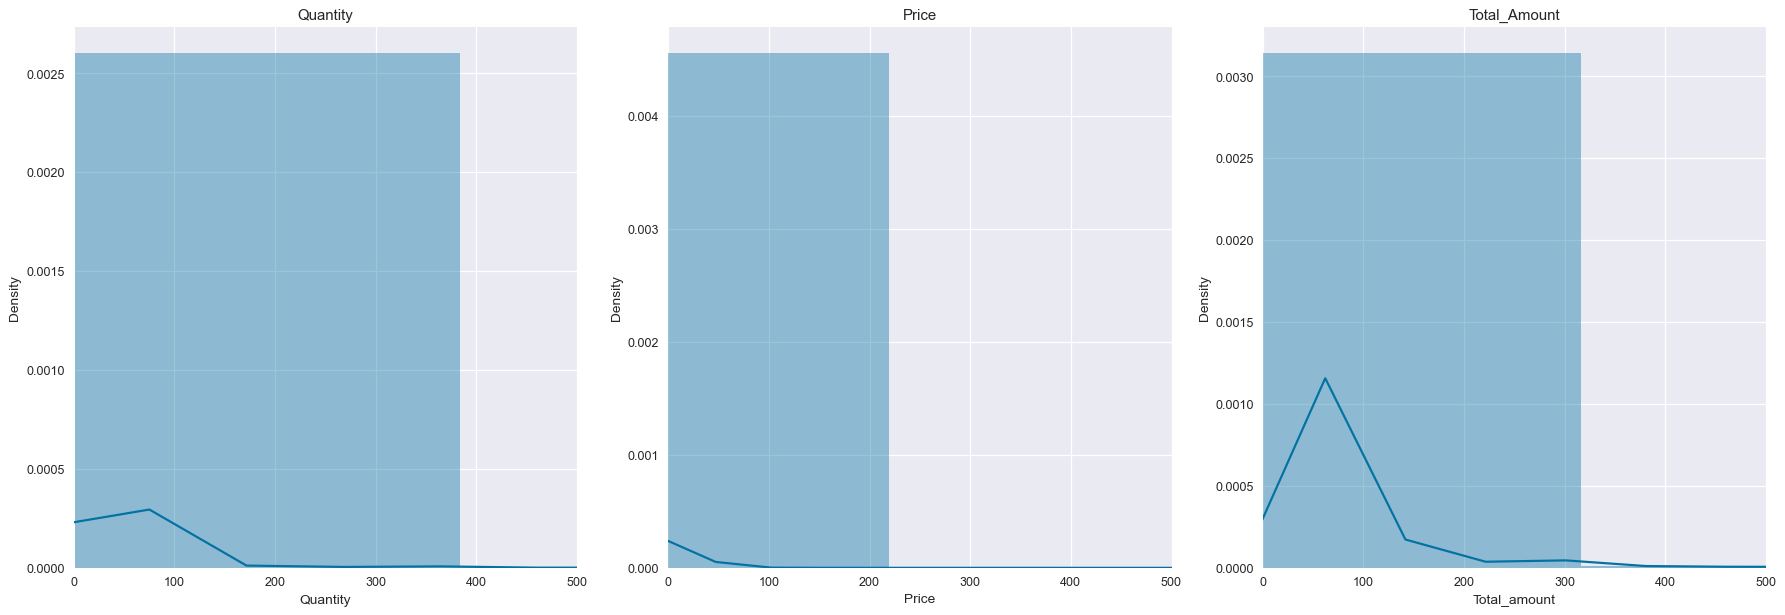

In [47]:
target3 = ['Quantity', 'Price', 'Total_amount']

plt.figure(figsize=(20,7), dpi=90)
for n,col in enumerate(target3):
    plt.subplot(1, 3, n+1)
    sns.distplot(data[col])
    plt.title(col.title())
    plt.xlim(0, 500) 
    plt.tight_layout() 

The density plots exhibit positively skewed distribution because most of the values are clustered to the left

#### 10.4 Visualizing the distributions after log transformation of quantity

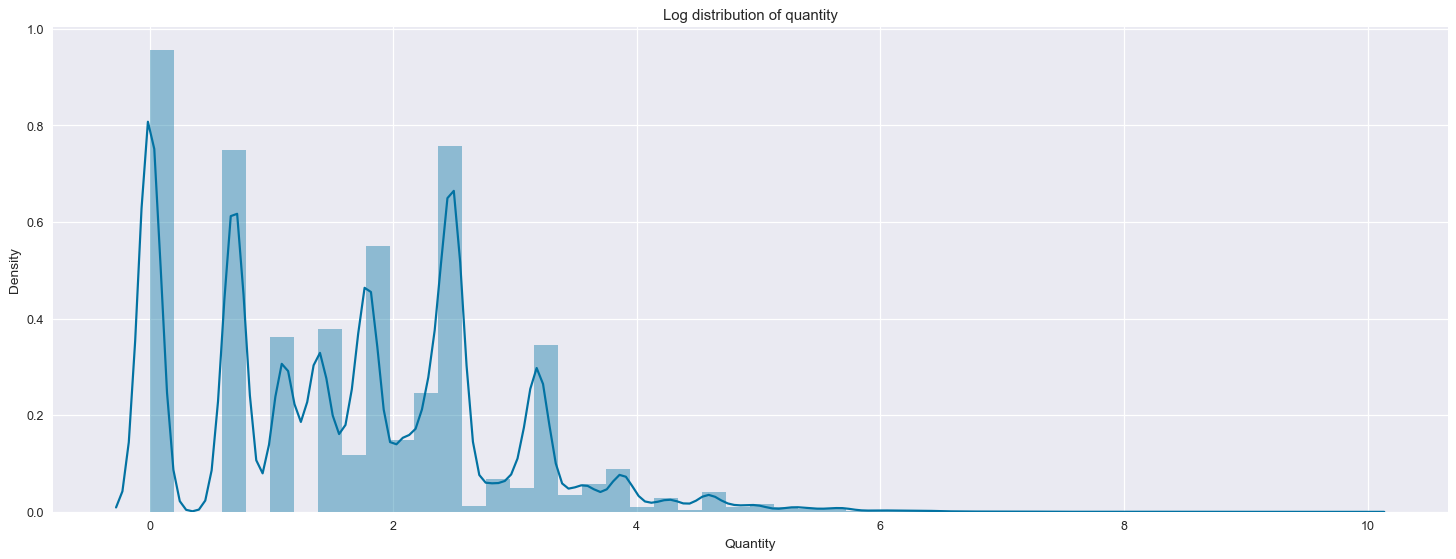

In [48]:
plt.figure(figsize=(20,7), dpi=90)
plt.title('Log distribution of quantity')
sns.distplot(np.log(data['Quantity'])) 
plt.show() 

#### 10.5 Customers per country

In [49]:
customer_count = data.groupby('Country').nunique()['Customer ID'].reset_index().sort_values('Customer ID', ascending=False) 
customer_count.rename(columns={'Customer ID':'Customer_count'}, inplace=True)
customer_count.head() 

,Country,Customer_count
34,United Kingdom,3971
12,Germany,67
11,France,47
28,Spain,25
21,Netherlands,22


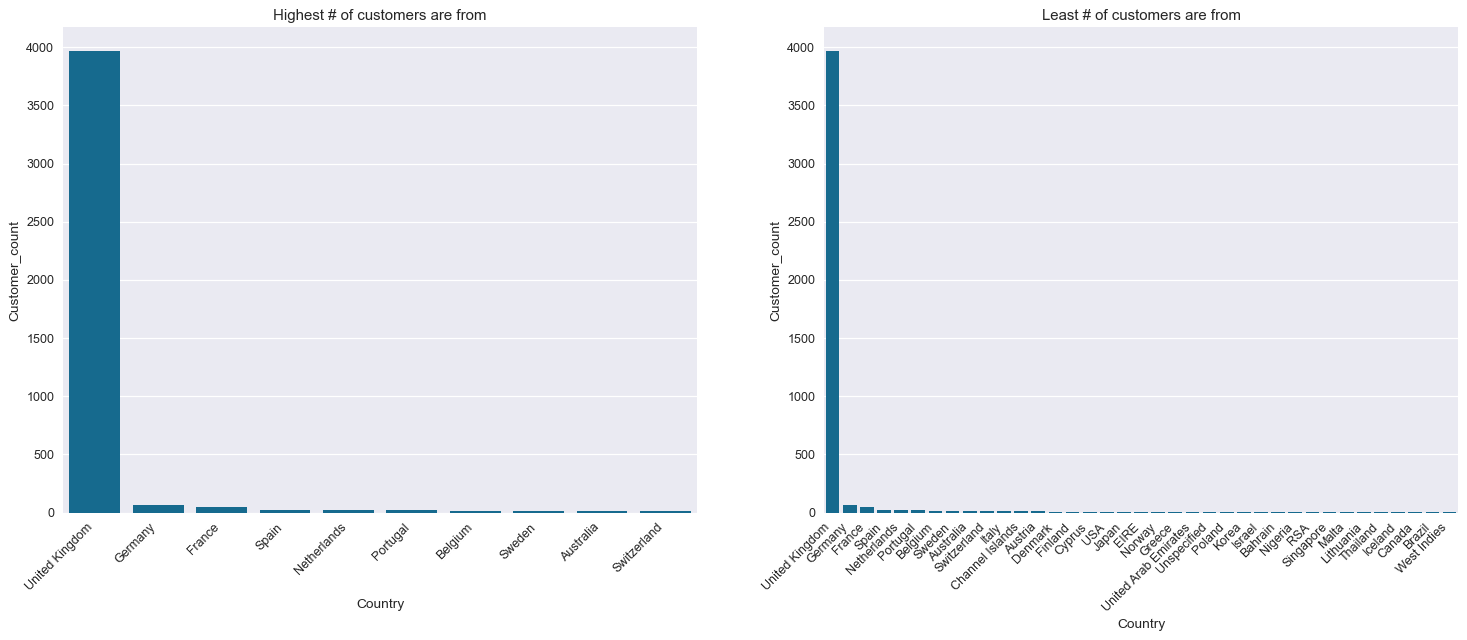

In [52]:
plt.figure(figsize=(20,7), dpi=90) 
plt.subplot(1,2,1)
plt.xticks(rotation=45, ha='right') 
plt.title('Highest # of customers are from') 
sns.barplot(data=customer_count.head(10), x='Country', y='Customer_count')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45, ha='right') 
plt.title('Least # of customers are from') 
sns.barplot(data=customer_count, x='Country', y='Customer_count')
plt.show()

#### 10.6 Number of cancellations countrywise

In [64]:
con_cancel = cancel_df.groupby('Country').count()['Invoice'].reset_index().sort_values('Invoice', ascending=False)
con_cancel.rename(columns={'Invoice': 'Cancellations'}, inplace=True)
con_cancel.head()

,Country,Cancellations
24,United Kingdom,8450
9,Germany,468
8,France,240
6,EIRE,202
3,Channel Islands,85


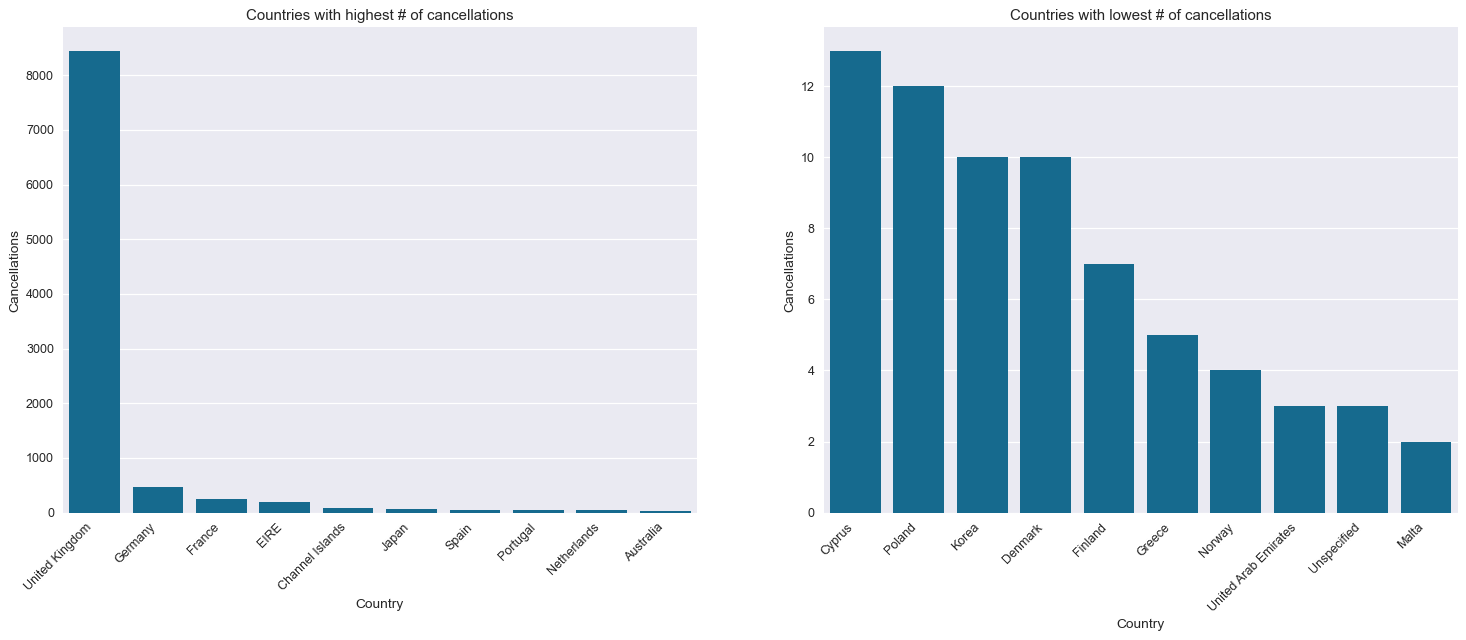

In [65]:
plt.figure(figsize=(20,7), dpi=90) 
plt.subplot(1, 2, 1) 
plt.xticks(rotation=45, ha='right') 
plt.title('Countries with highest # of cancellations')
sns.barplot(data=con_cancel.head(10), x='Country', y='Cancellations') 

plt.subplot(1, 2, 2) 
plt.xticks(rotation=45, ha='right') 
plt.title('Countries with lowest # of cancellations')
sns.barplot(data=con_cancel.tail(10), x='Country', y='Cancellations') 
plt.show() 

## 11. RFM Modelling

Adding 1 day to the Last Invoice date to set as Latest date for reference

In [66]:
LatestDate = data["InvoiceDate"].max() + pd.DateOffset(days=1)

Creating a new dataframe to calculate Recency, Frequency and Monetary scores for each customer

In [67]:
rfm = data.groupby('Customer ID').agg({'InvoiceDate': lambda x:(LatestDate-x.max()).days, 'Invoice': lambda x:len(x), 'Total_amount': lambda x:x.sum()})

Renaming Columns

In [68]:
rfm.rename(columns={'InvoiceDate':'Recency','Invoice':'Frequency','Total_amount':'Monetary'}, inplace=True)
rfm.reset_index().head() 

,Customer ID,Recency,Frequency,Monetary
0,12346.0,165,33,372.86
1,12347.0,3,71,1323.32
2,12348.0,74,20,222.16
3,12349.0,43,102,2671.14
4,12351.0,11,21,300.93


Calculating RFM scores

In [69]:
rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=[4,3,2,1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'], q=4, labels=[1,2,3,4]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], q=4, labels=[1,2,3,4]).astype(int)

Finding the RFM Group for each customer by combining the factors R,Fand M


In [70]:
rfm['RFM'] = 100*rfm['R']+10*rfm['F']+rfm['M']

Finding the RFM Score for each customer by adding the factors R,Fand M


In [71]:
rfm['RFM_Score'] = rfm['R']+rfm['F']+rfm['M'] 

Handling the zeroes in the dataframe to avoid error in transformations

In [72]:
rfm.replace(0.0, 1, inplace=True) 

Applying Log transformation on columns for smoothening the distribution

In [73]:
rfm['Recency_Log'] = rfm['Recency'].apply(np.log) 
rfm['Frequency_Log'] = rfm['Frequency'].apply(np.log) 
rfm['Monetary_Log'] = rfm['Monetary'].apply(np.log) 
rfm.head() 

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score,Recency_Log,Frequency_Log,Monetary_Log
Customer ID,,,,,,,,,,,
12346.0,165,33,372.86,1,2,2,122,5,5.105945,3.496508,5.921203
12347.0,3,71,1323.32,4,3,3,433,10,1.098612,4.262680,7.187899
12348.0,74,20,222.16,2,2,1,221,5,4.304065,2.995732,5.403398
12349.0,43,102,2671.14,3,4,4,344,11,3.761200,4.624973,7.890261
12351.0,11,21,300.93,4,2,1,421,7,2.397895,3.044522,5.706878


1. A customer with RFM 444 is the best customer with good recency, frequent and spending more money
2. A customer with RFM 111 is a churing customer with low recency, less frequent and spending less money
3. A customer with RFM 144 is the customer who purchased a long time ago but used to buy frequently and spend more.

**Higher the RFM score, more valuable the customer is**

#### Visualizing RFM before and after transformations

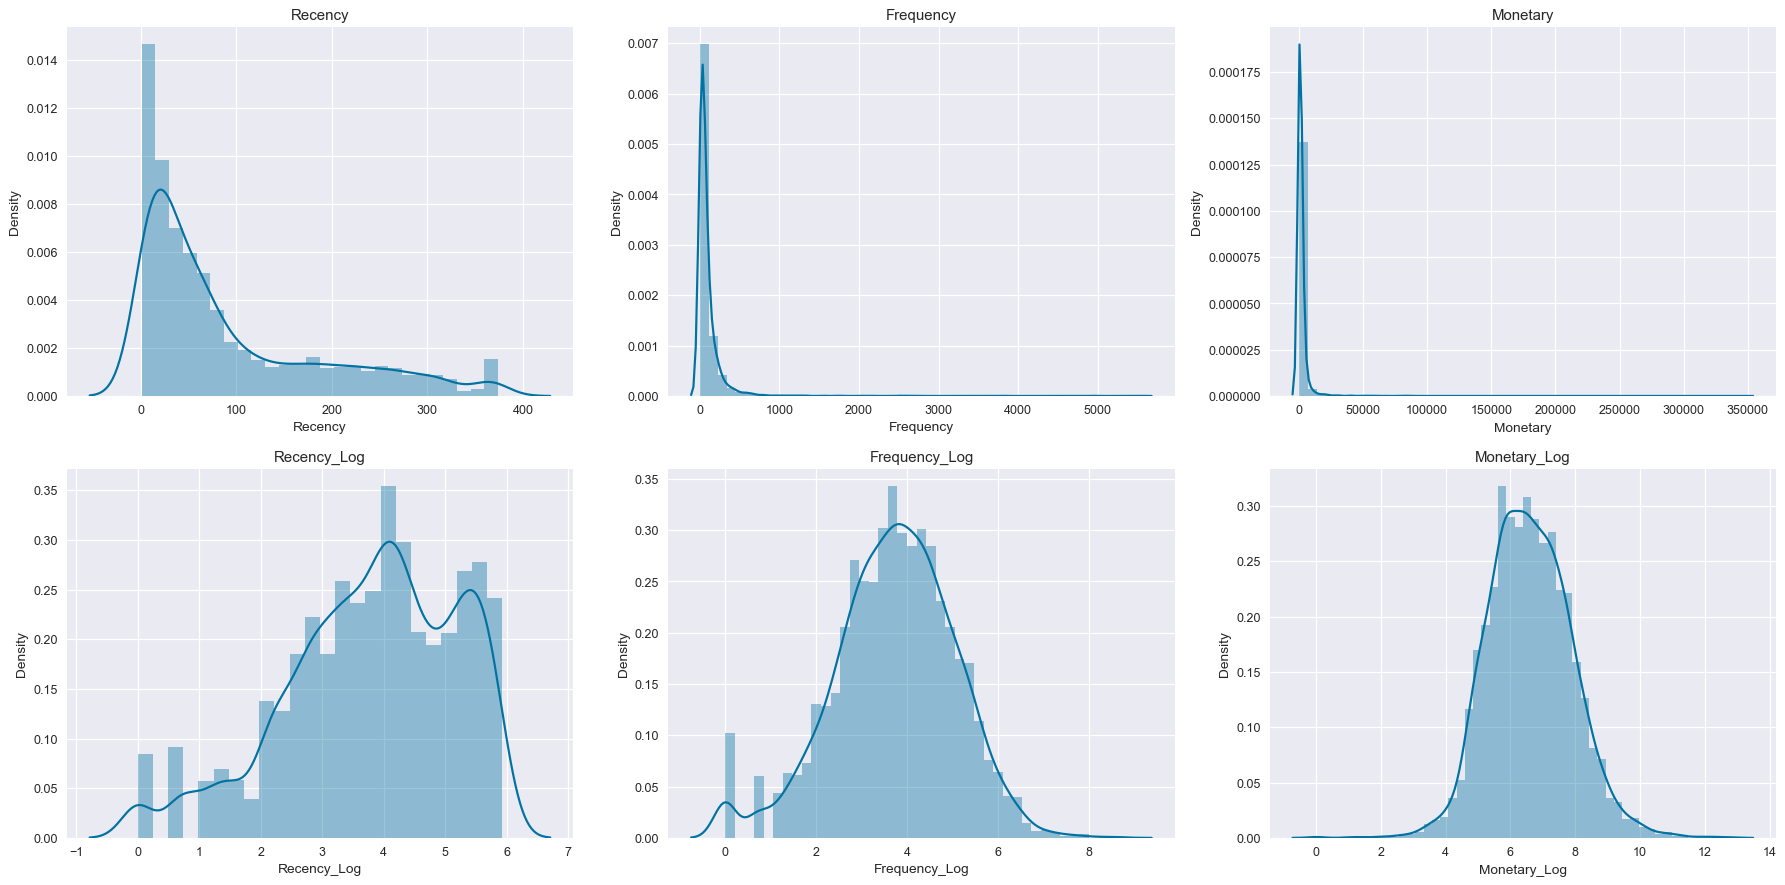

In [74]:
target4 = ['Recency', 'Frequency', 'Monetary', 'Recency_Log', 'Frequency_Log', 'Monetary_Log']
plt.figure(figsize=(20,10), dpi=90)
for n,col in enumerate(target4):
    plt.subplot(2, 3, n+1)
    sns.distplot(rfm[col])
    plt.title(col.title())
    plt.tight_layout() 

Distribution of Recency, Frequency and Monetary columns were positively skewed before transformation and approaches normal distribution after transformation. So, we will consider transformed features for further analysis

## 12. Correlation Analysis

Text(0.5, 1.0, 'RFM Correlation heatmap')

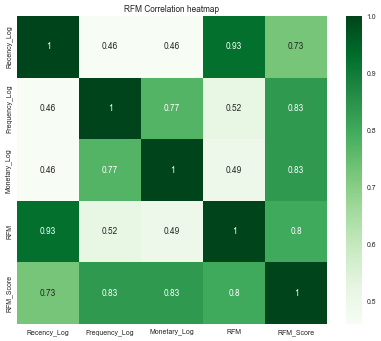

In [79]:
target5 = ['Recency_Log', 'Frequency_Log', 'Monetary_Log', 'RFM', 'RFM_Score'] 
plt.figure(figsize=(10,8), dpi=50) 
sns.heatmap(abs(rfm[target5].corr()), annot=True, cmap='Greens') 
plt.title('RFM Correlation heatmap')

## 13. Clustering Algorithms

In [80]:
X = rfm[['Recency_Log', 'Frequency_Log', 'Monetary_Log']]
X = StandardScaler().fit_transform(X) 

In [91]:
conclusion = {} 

def del_outliers(col, overlap_supress):
    condition1 = col<col.quantile(1-overlap_supress)
    condition2 = col>col.quantile(overlap_supress)
    return col[condition1 & condition2] 

def cluster_stats(df, segment_name):

    # Storing the mean median and count of Recency, Frequency and Monetary for each group
    stats = df[["Recency","Frequency","Monetary",segment_name]].groupby(segment_name).agg(['mean','median'])
    stats['Count'] = df[segment_name].value_counts() 

    # Storing 0.25th and 0.75th Quantile of Recency, Frequency and Monetary for each group
    summary = df[["Recency","Frequency","Monetary",segment_name]].groupby(segment_name).agg({
          "Recency"   :lambda x : f'{int(x.quantile(0.25))} to {int(x.quantile(0.75))} days ago',
          "Frequency" :lambda x : f"Bought {int(x.quantile(0.25))} to {int(x.quantile(0.75))} times",
          "Monetary"  :lambda x : f"Spent around {int(x.quantile(0.25))} to {int(x.quantile(0.75))} Sterling"})
  
    # Changing the name for the columns 
    stats.columns = [f'{i}_{j}' for i, j in stats.columns]
    summary.columns=["Last_visited",'Purchase_frequency',"Money_spent"]

    return stats, summary 

# Defining a function for plotting clusters for Visualization
def plots_stats_summary(y, segment_name, er,title, overlap_supress=0.2):
    rfm[segment_name] = y 
    groups = sorted(rfm[segment_name].unique())
    stats, summary = cluster_stats(rfm, segment_name)

    plt.figure(figsize=(20,7), dpi=90)
    ax = plt.axes(projection='3d') 
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency') 
    ax.set_zlabel('Monetary') 
    ax.set_title(title) 
    ax = ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap='viridis') 
    plt.legend(*ax.legend_elements(), prop={'size':15}) 

    fig,ax = plt.subplots(3, figsize=(18,18), dpi=90) 

    for i in groups:
        for index,col in enumerate(['Recency', 'Frequency', 'Monetary']):
            sns.distplot(del_outliers(rfm[rfm[segment_name]==i][col], overlap_supress), ax=ax[index], kde_kws=dict(linewidth=5))
            ax[index].set_title(f'{col} Distribution')
            ax[index].legend(groups, prop={'size':15}) 
    plt.show()

    print('\n\nDisplaying the mean median and count of Recency, Frequency and Monetary for each group with the description:\n')
    display(stats.reset_index().style.background_gradient(cmap='Greens'))
    display(summary.reset_index().style.set_properties(**{'text-align': 'left'}).background_gradient(cmap=er))

    return stats, summary 

## A. Binning RFM_Score

Grouping customers based on their RFM scores into segments or bins. RFM scores help in customer segmentation as they provide insights into customer behavior and help to identify high value customers, frequant shoppers and potential churners

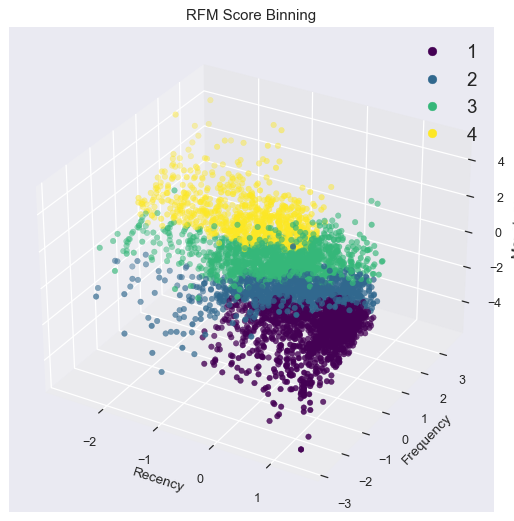

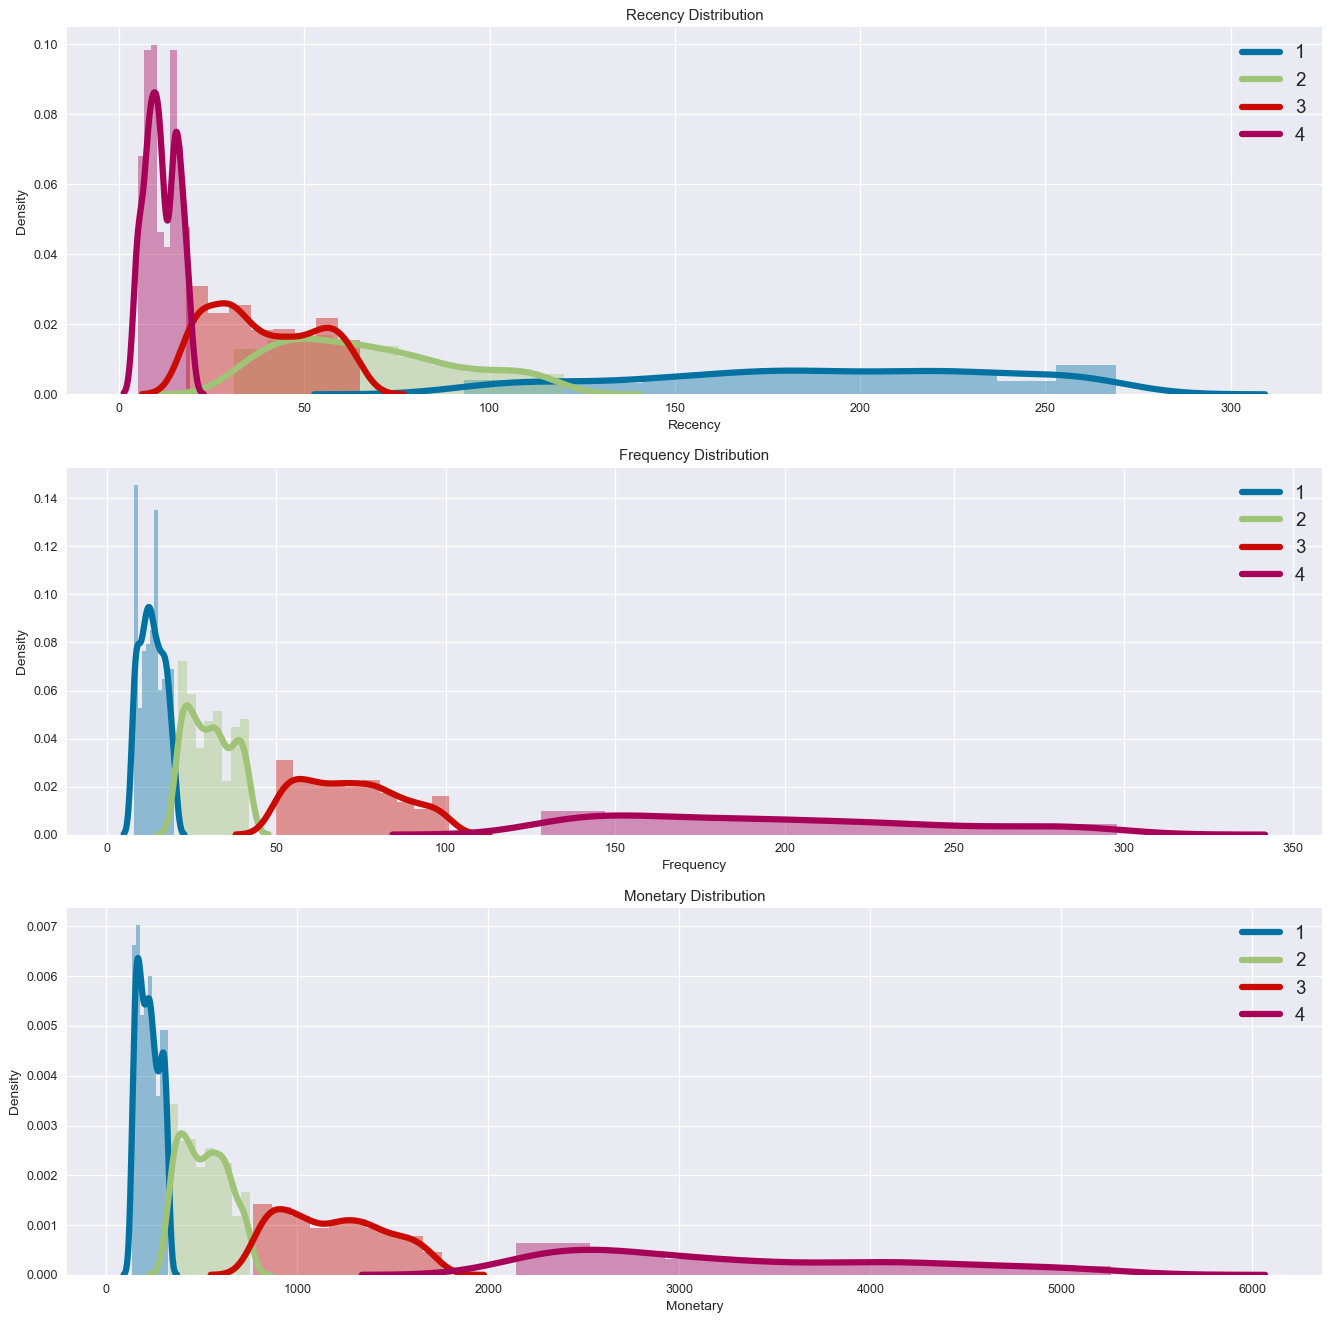



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



,Binning,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,1,189.197240,191.000000,15.362825,13.000000,256.416633,218.125000,1232
1,2,88.412500,64.000000,34.152083,30.000000,709.055167,506.275000,960
2,3,48.867997,36.000000,89.427475,71.000000,1705.829467,1179.450000,1303
3,4,14.765568,11.000000,284.139194,191.000000,6811.894623,3096.140000,819


,Binning,Last_visited,Purchase_frequency,Money_spent
0,1,92 to 270 days ago,Bought 7 to 21 times,Spent around 135 to 323 Sterling
1,2,30 to 121 days ago,Bought 20 to 43 times,Spent around 327 to 753 Sterling
2,3,17 to 66 days ago,Bought 49 to 102 times,Spent around 767 to 1756 Sterling
3,4,4 to 21 days ago,Bought 127 to 302 times,Spent around 2140 to 5263 Sterling


In [92]:
y = pd.qcut(rfm['RFM_Score'], q=4, labels=[1,2,3,4]).astype(int)

title = 'RFM Score Binning'
segment_name = 'Binning'
overlap_supress = 0.25
color = 'Oranges'
conclusion[segment_name] = plots_stats_summary(y, segment_name, color,title, overlap_supress)

## B. Quantile Based Clustering

Groups data points into clusters based on their distribution within quantiles. 

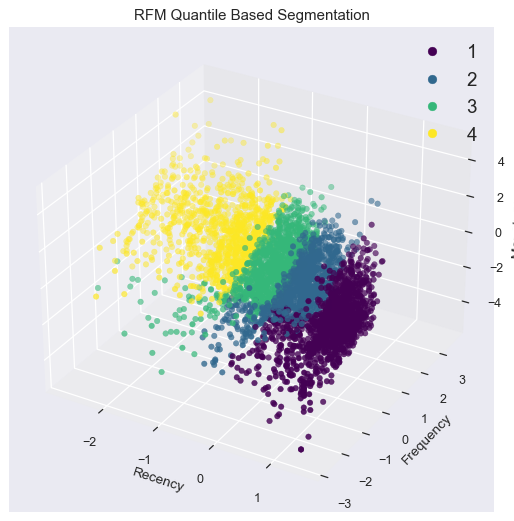

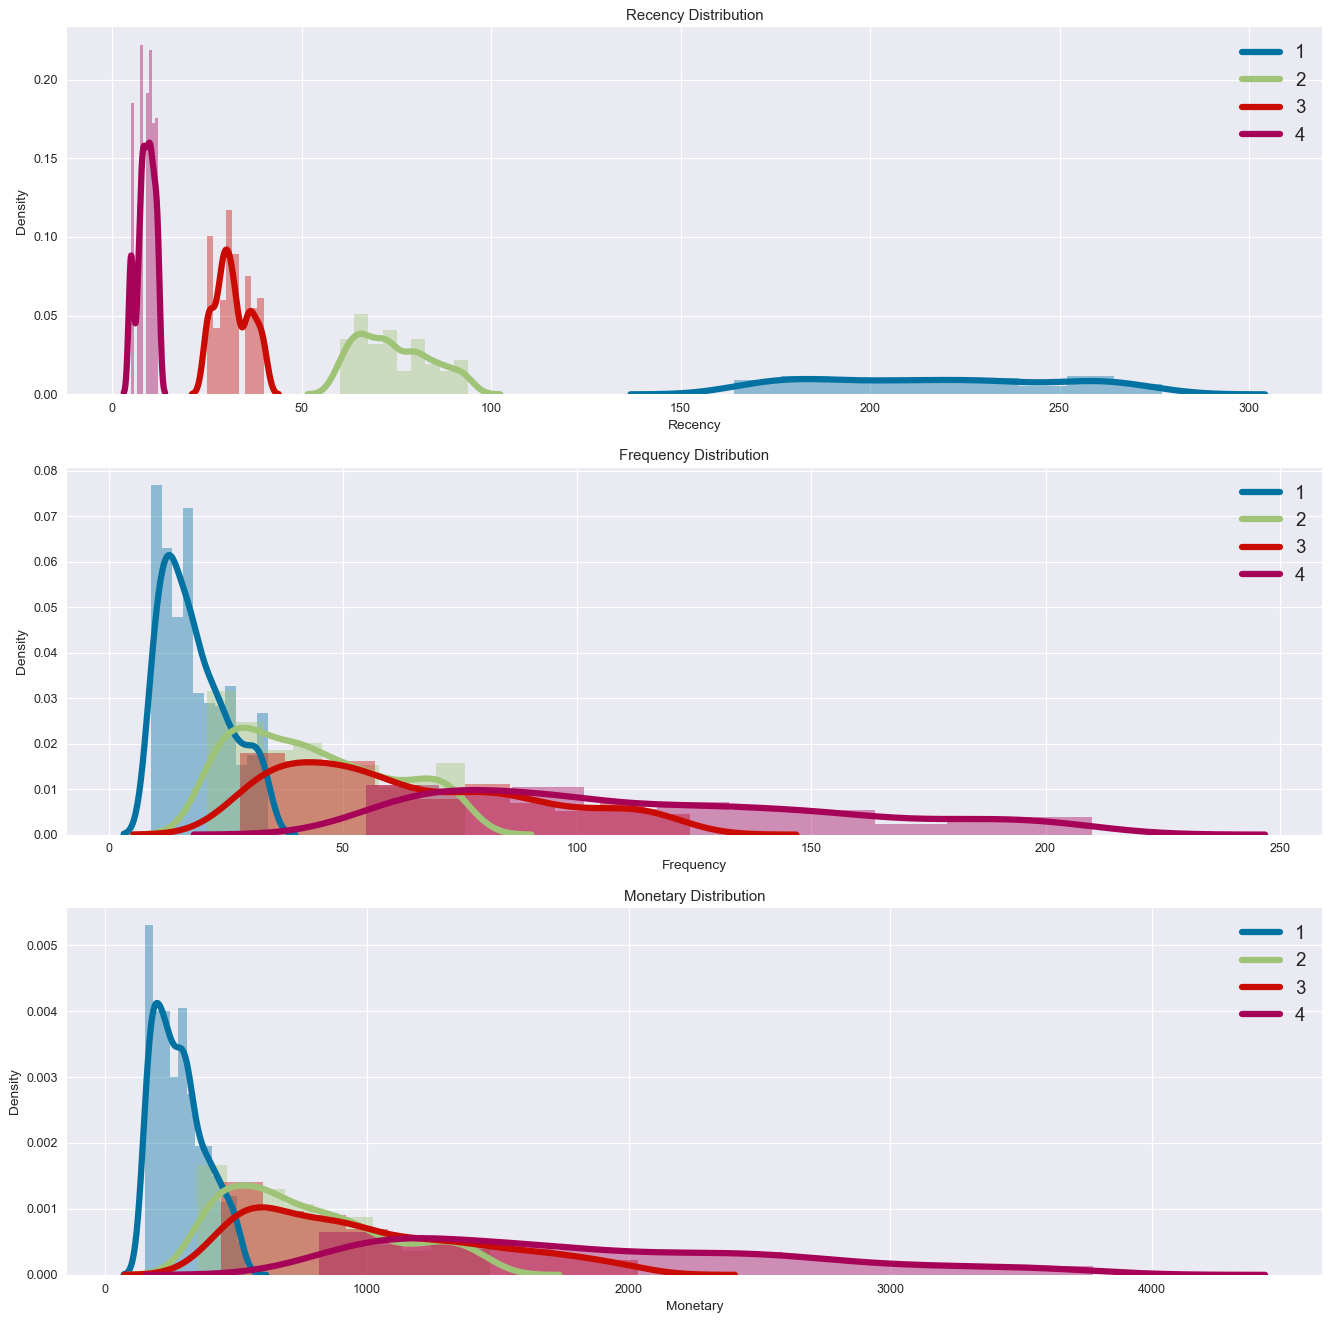



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



,QuantileCut,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,1,218.884984,216.000000,28.066294,17.000000,572.412016,270.985000,1252
1,2,76.865597,73.000000,64.334002,41.000000,1269.541877,717.570000,997
2,3,32.590953,31.000000,99.823869,57.000000,1702.253528,895.760000,1039
3,4,8.961014,9.000000,192.933723,104.500000,4919.299447,1700.695000,1026


,QuantileCut,Last_visited,Purchase_frequency,Money_spent
0,1,163 to 278 days ago,Bought 8 to 35 times,Spent around 151 to 535 Sterling
1,2,59 to 95 days ago,Bought 20 to 77 times,Spent around 352 to 1471 Sterling
2,3,24 to 42 days ago,Bought 27 to 124 times,Spent around 442 to 2038 Sterling
3,4,4 to 14 days ago,Bought 54 to 211 times,Spent around 816 to 3783 Sterling


In [93]:
# Splitting RFM in 4 segments based on quantiles to obtain segments
y = pd.qcut(rfm['RFM'], q=4, labels=[1,2,3,4]).astype(int)

# Plotting Segments for Visualization
title = 'RFM Quantile Based Segmentation'
segment_name = 'QuantileCut'
overlap_supress = 0.25
color='BuPu'
conclusion[segment_name] = plots_stats_summary(y, segment_name, color,title, overlap_supress)

## C. K-Means Clustering

K-means clustering is a popular unsupervised machine learning algorithm used for clustering data points based on their similarity. It divides the data set into K clusters, where K is a predefined number

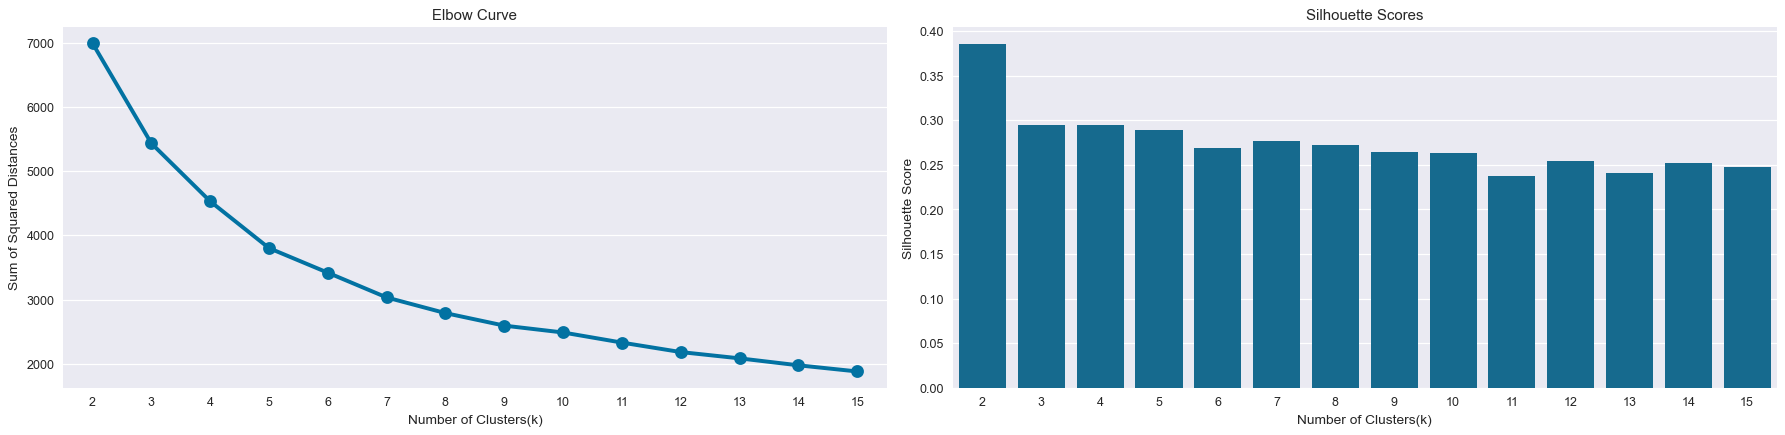

In [94]:
# Storing sum of squared distances and Silhouette Scores for each value of k in k means clusterer
ssd,score = [],[]
# Setting figure Size
plt.figure(figsize=(20,5), dpi=90)

# Initializing the list of clusters for tuning the best clusters
n_clusters = list(range(2,16))

# Running a for loop of Kmeans algorithm
for k in n_clusters:
    clusterer = KMeans(n_clusters = k, init= 'k-means++', max_iter= 1000)
    y_preds = clusterer.fit_predict(X)                                          # Fitting the model
    ssd.append(clusterer.inertia_)                                              # Appending the inertia
    score.append(silhouette_score(X, y_preds))                                  # Appending the silhoutte score

# Plotting Elbow curve to find optimal K
plt.subplot(1, 2, 1)                                                            #Initializing subplots
sns.pointplot(x=n_clusters, y=ssd)                                              # plotting point plot
plt.xlabel('Number of Clusters(k)')                                             # Setting x label
plt.ylabel('Sum of Squared Distances')                                          # Setting y label
plt.title('Elbow Curve')                                                        # Setting the title

# Silhouette Score v/s Number of Clusters
plt.subplot(1, 2, 2)                                                            #Initializing subplots
sns.barplot(x=n_clusters, y=score)                                              # plotting bar plot
plt.xlabel('Number of Clusters(k)')                                             # Setting x label
plt.ylabel('Silhouette Score')                                                  # Setting y label
plt.title('Silhouette Scores')                                                  # Setting the title
plt.tight_layout() 

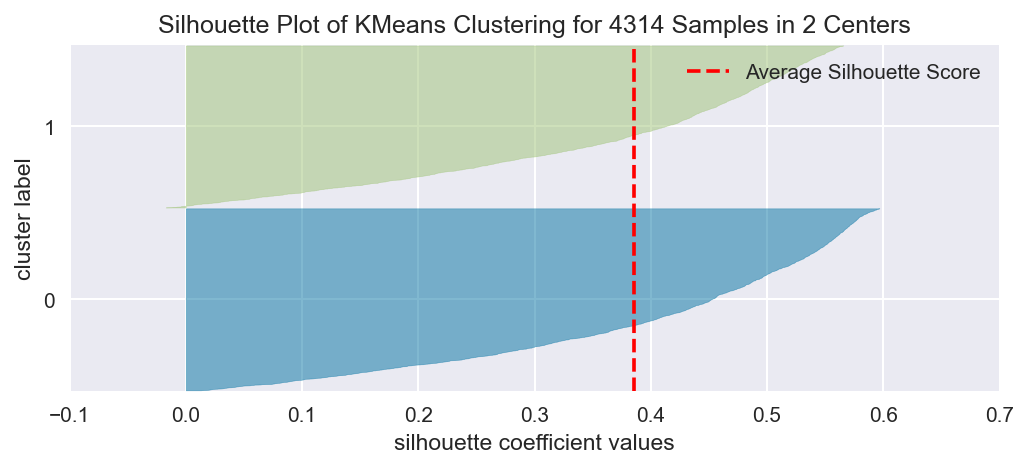

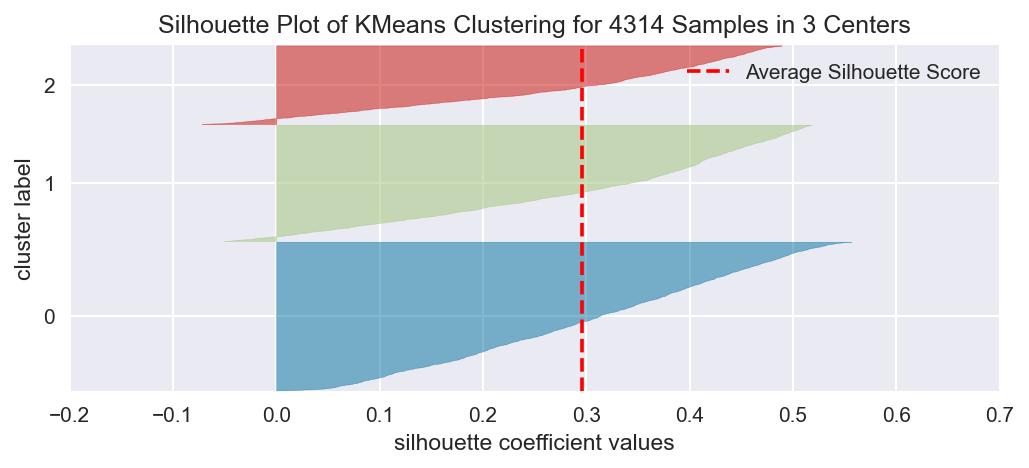

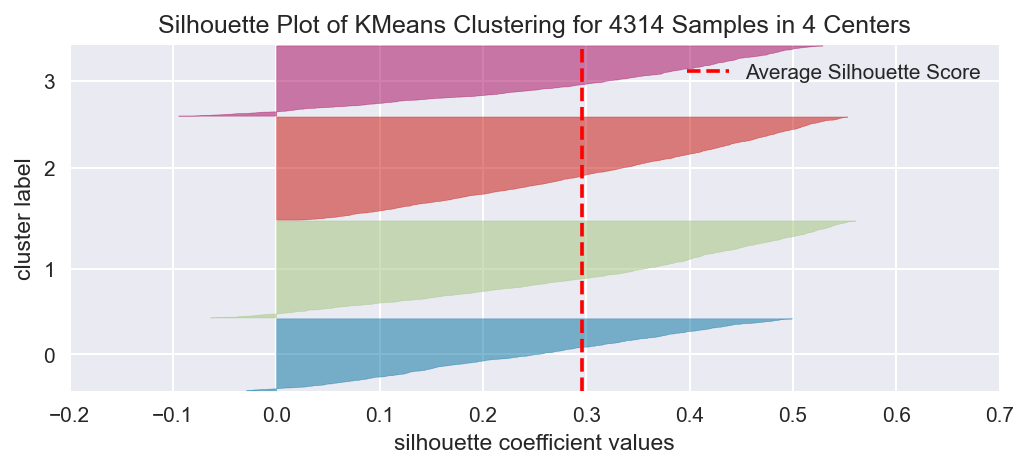

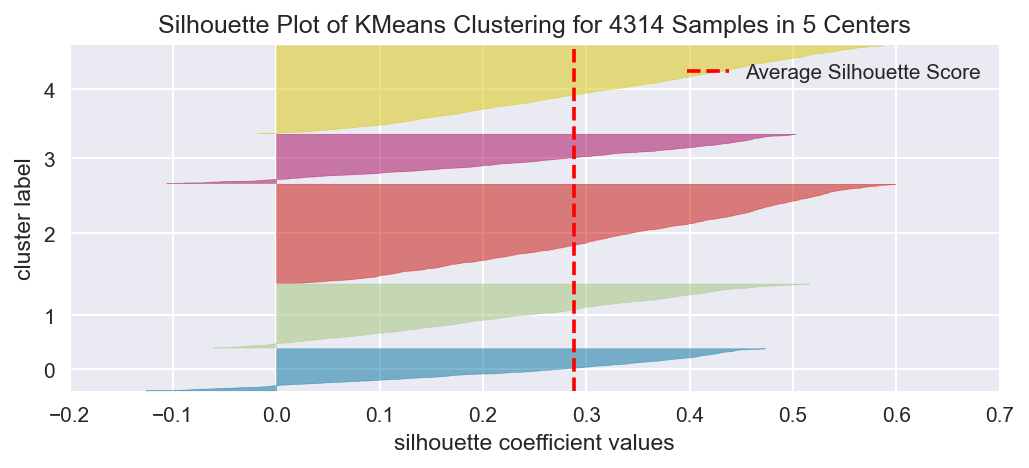

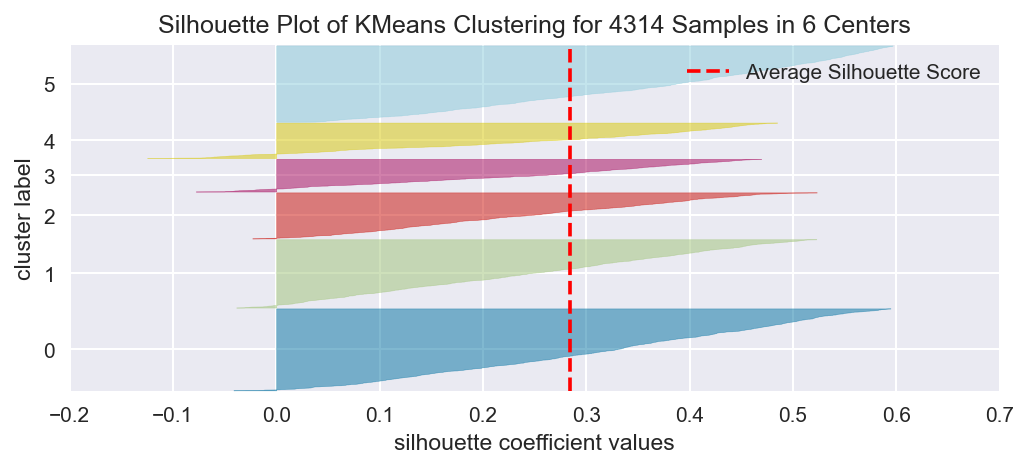

In [95]:
# Visualizing the Silouette plots for the clusters
for i in range(2,7):
    plt.figure(figsize = (8, 3), dpi=150)
    kmeans=KMeans(i,init="k-means++")
    visualizer=SilhouetteVisualizer(kmeans,colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show() 

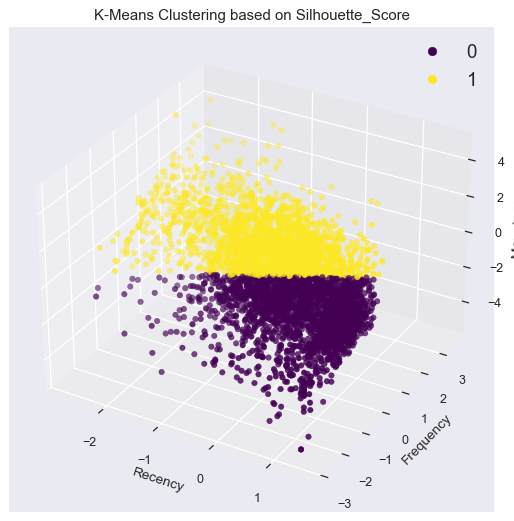

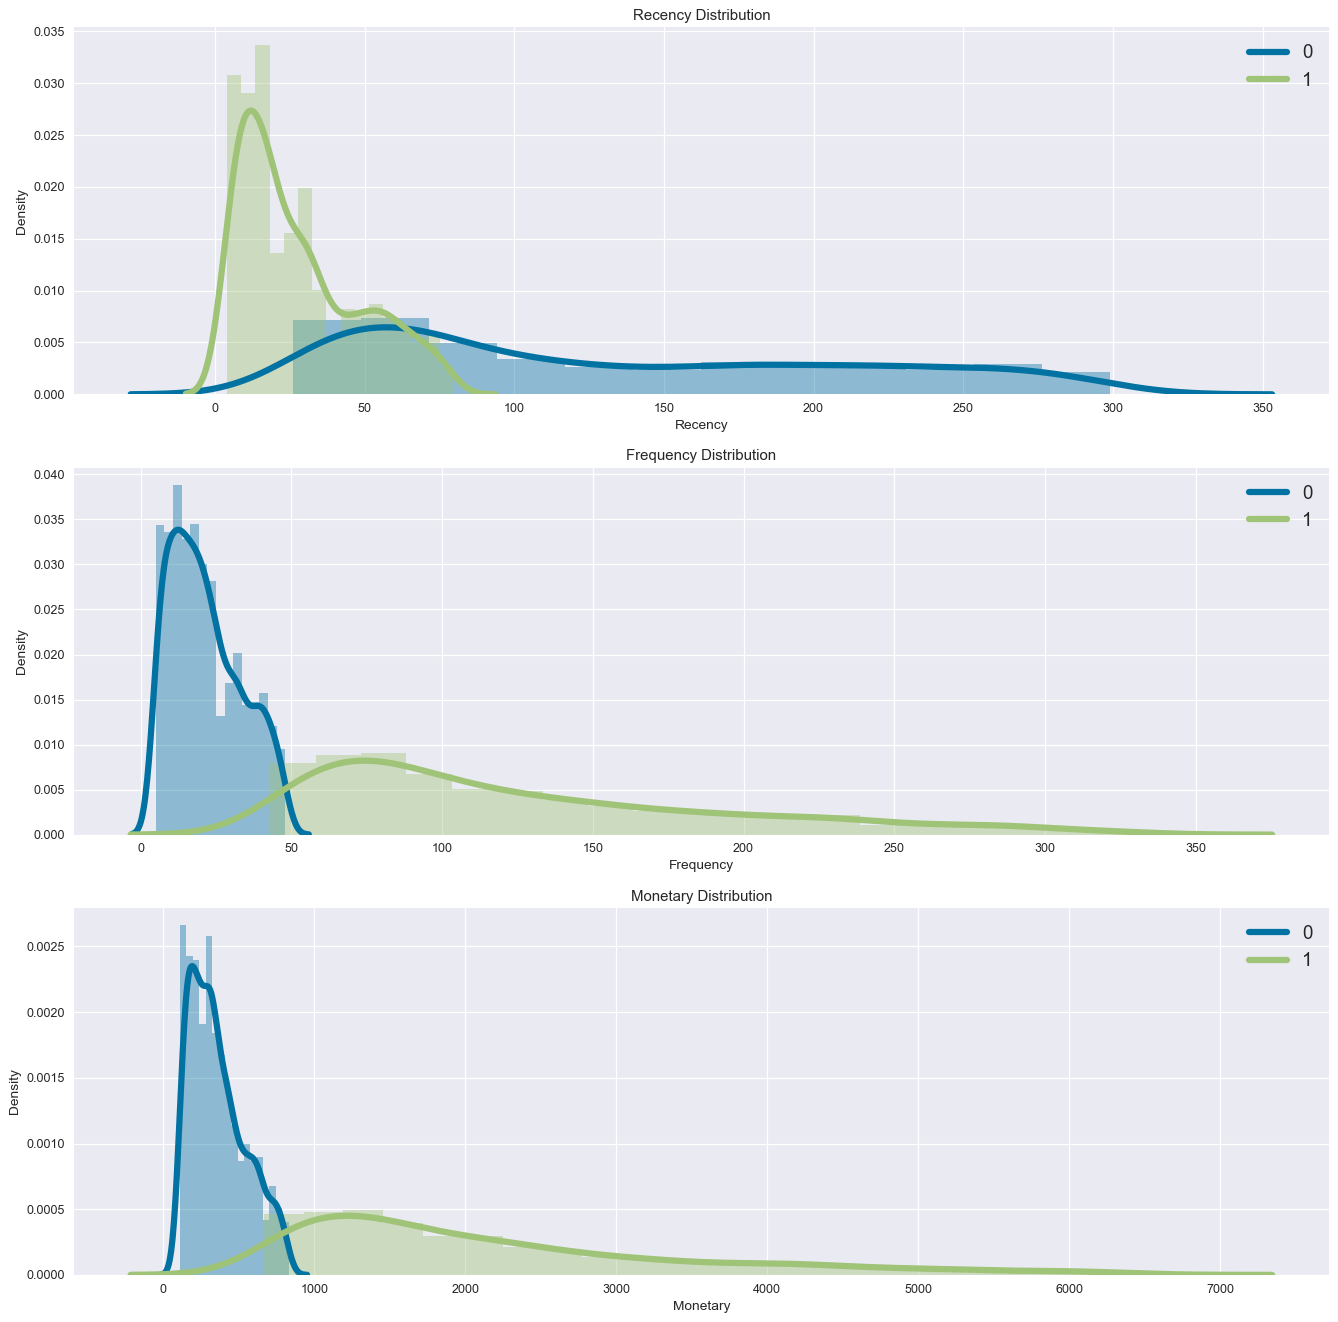



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



,K-Means|2Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,0,140.968887,110.000000,24.139790,19.500000,442.659620,321.270000,2282
1,1,35.454724,21.000000,170.206693,105.500000,3832.719730,1766.365000,2032


,K-Means|2Cluster,Last_visited,Purchase_frequency,Money_spent
0,0,51 to 225 days ago,Bought 10 to 34 times,Spent around 182 to 546 Sterling
1,1,9 to 49 days ago,Bought 67 to 190 times,Spent around 1052 to 3232 Sterling


In [96]:
# Fitting the model on n_clusters = 2 based on Silhouette_Score to visualise the segments.
kmc = KMeans(n_clusters=2,init="k-means++")          
y = kmc.fit_predict(X)                                  
centers = kmc.cluster_centers_                          

# Plotting Clusters for Visualization
title = 'K-Means Clustering based on Silhouette_Score' 
segment_name = 'K-Means|2Cluster'
overlap_supress = 0.1
color="inferno"
conclusion[segment_name] = plots_stats_summary(y, segment_name, color,title, overlap_supress)

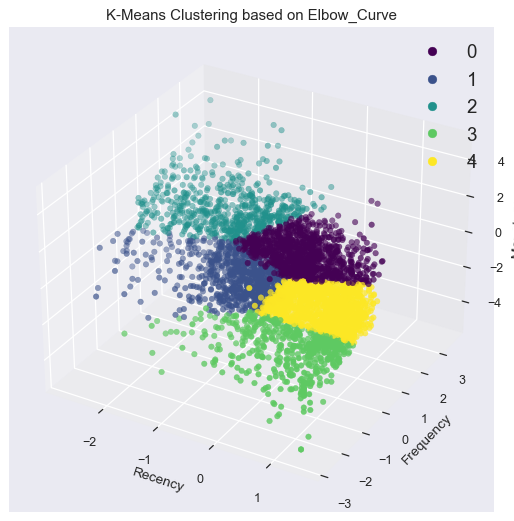

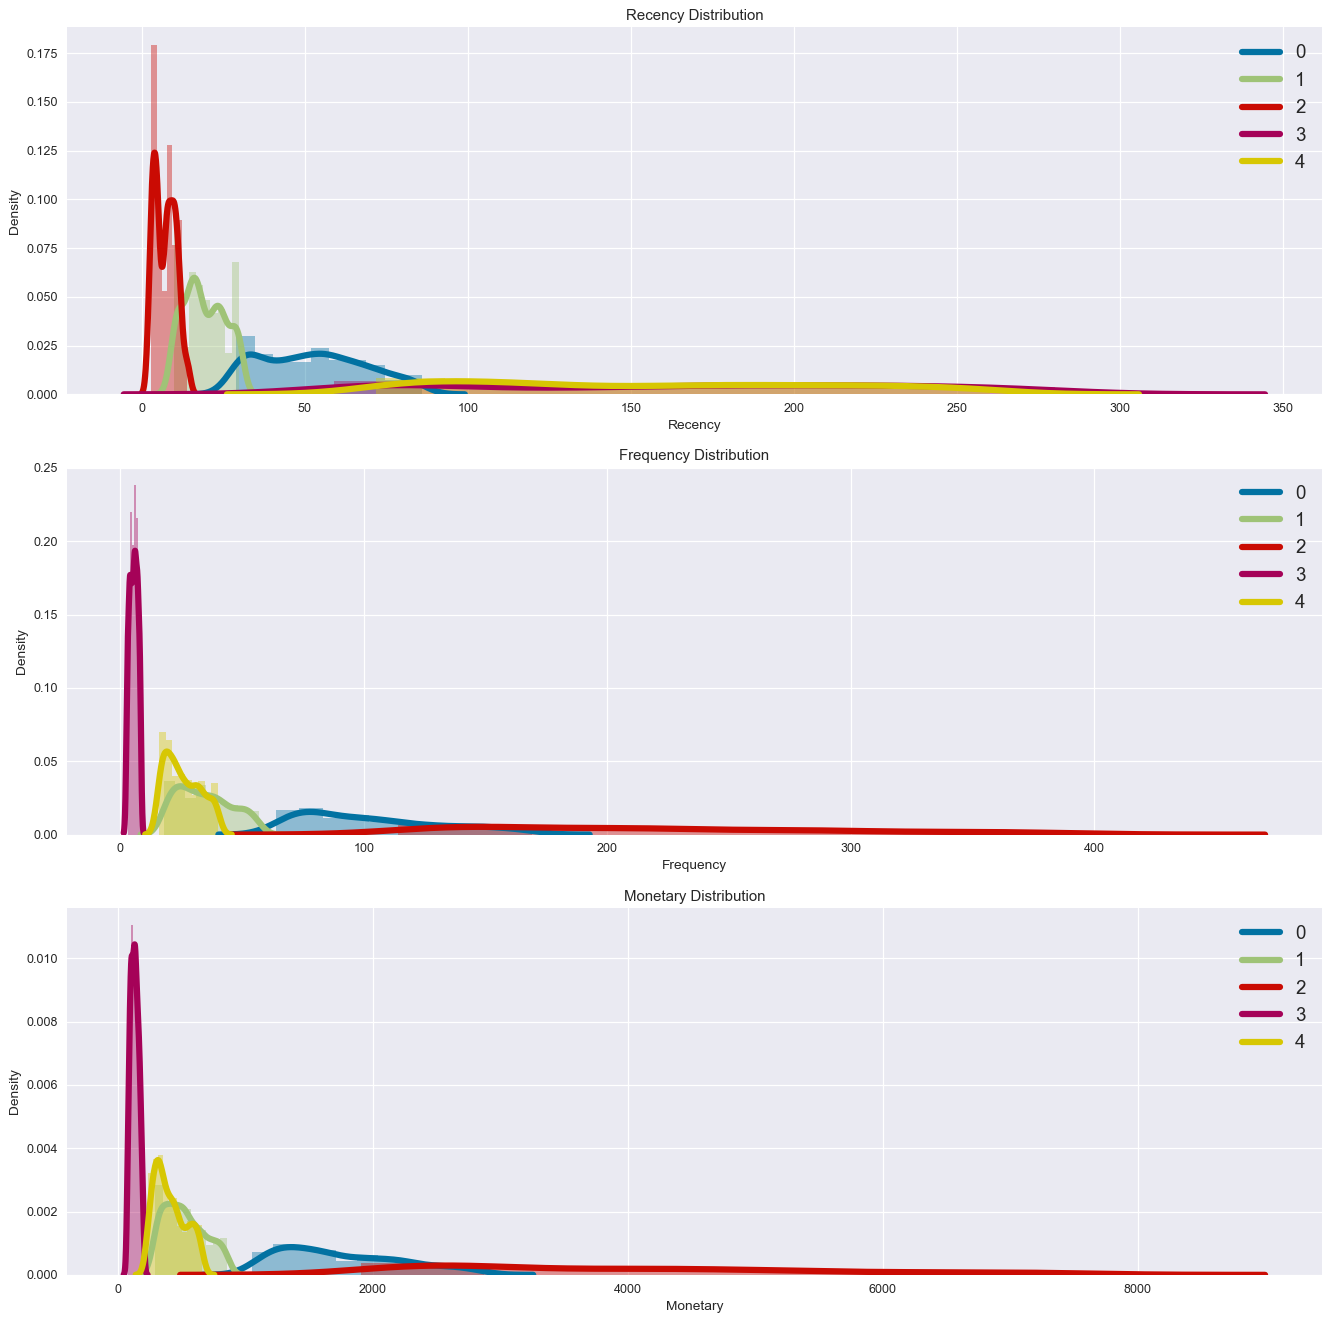



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



,K-Means|5Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,0,65.593128,52.000000,122.196203,96.000000,2289.371479,1652.510000,1106
1,1,20.288366,18.000000,39.418317,33.000000,607.854791,503.395000,808
2,2,8.535370,7.000000,312.581994,206.000000,8135.246600,3635.360000,622
3,3,170.171103,170.000000,5.576046,5.000000,172.919106,130.025000,526
4,4,167.713259,151.000000,29.224441,25.000000,498.374906,385.195000,1252


,K-Means|5Cluster,Last_visited,Purchase_frequency,Money_spent
0,0,30 to 78 days ago,Bought 68 to 152 times,Spent around 1177 to 2541 Sterling
1,1,10 to 29 days ago,Bought 20 to 52 times,Spent around 317 to 790 Sterling
2,2,3 to 12 days ago,Bought 126 to 352 times,Spent around 2157 to 6621 Sterling
3,3,67 to 261 days ago,Bought 2 to 8 times,Spent around 87 to 179 Sterling
4,4,79 to 241 days ago,Bought 17 to 38 times,Spent around 261 to 610 Sterling


In [97]:
# Fitting the model on n_clusters = 5 based on Elbow_Curve to visualise the segments.
kmc = KMeans(n_clusters=5,init="k-means++")           
y = kmc.fit_predict(X)                                
centers = kmc.cluster_centers_                        

# Plotting Clusters for Visualization
title = 'K-Means Clustering based on Elbow_Curve'     
segment_name = 'K-Means|5Cluster'
overlap_supress = 0.2
color="tab20"
conclusion[segment_name] = plots_stats_summary(y, segment_name,color, title, overlap_supress)

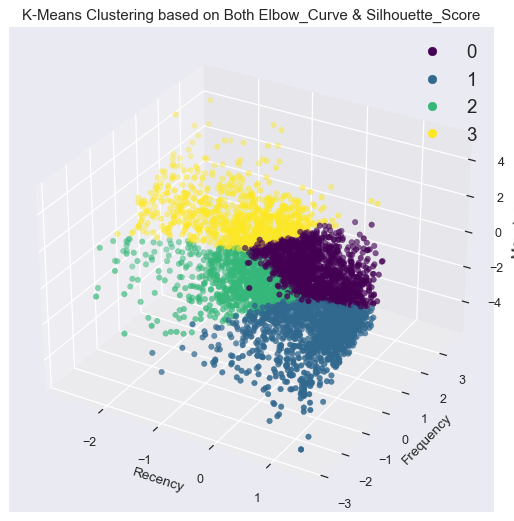

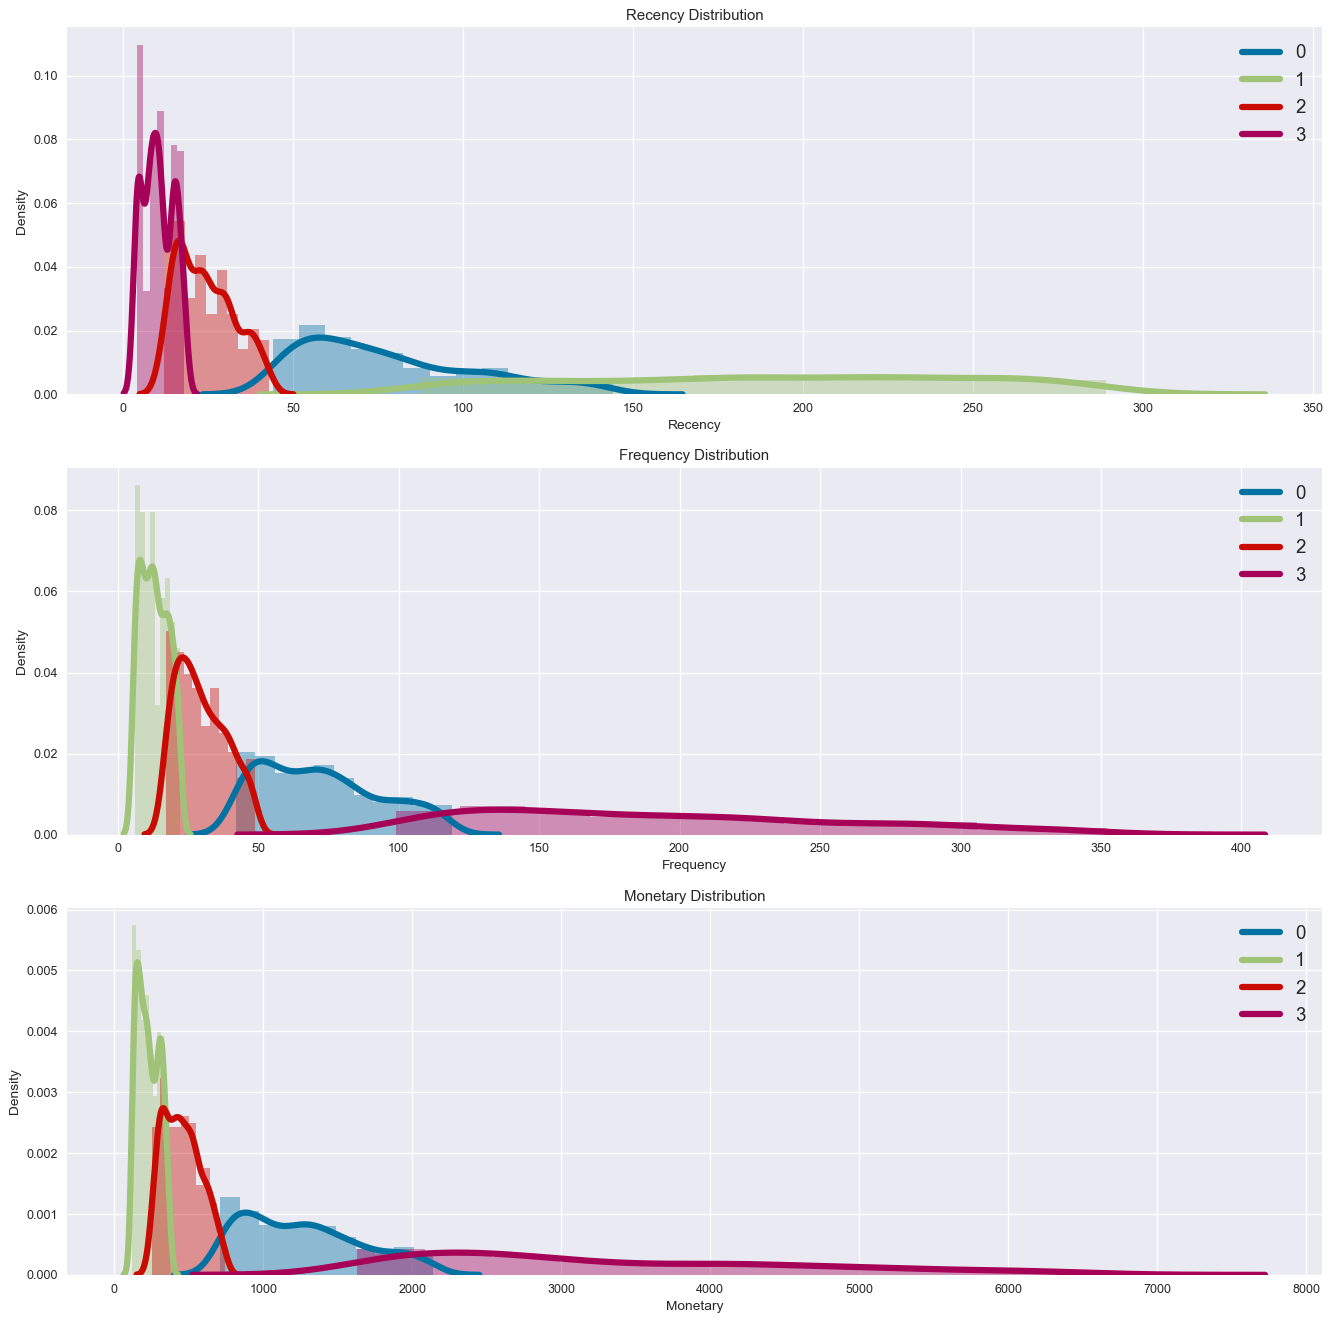



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



,K-Means|4Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,0,96.043210,72.000000,86.967593,70.000000,1685.350404,1222.695000,1296
1,1,193.123549,191.500000,15.097844,13.000000,281.836452,221.760000,1206
2,2,27.072264,23.000000,34.134963,28.000000,534.621553,443.160000,941
3,3,12.492537,10.000000,273.143513,182.000000,6625.772650,2960.730000,871


,K-Means|4Cluster,Last_visited,Purchase_frequency,Money_spent
0,0,49 to 123 days ago,Bought 45 to 109 times,Spent around 769 to 1922 Sterling
1,1,99 to 273 days ago,Bought 6 to 21 times,Spent around 135 to 336 Sterling
2,2,14 to 38 days ago,Bought 18 to 45 times,Spent around 295 to 646 Sterling
3,3,4 to 17 days ago,Bought 112 to 296 times,Spent around 1799 to 5394 Sterling


In [98]:
# Fitting the model on n_clusters = 4 based on Both Elbow_Curve & Silhouette_Score to visualise the segments.
kmc = KMeans(n_clusters=4,init="k-means++")         
y = kmc.fit_predict(X)                              
centers = kmc.cluster_centers_                      

# Plotting Clusters for Visualization
title = 'K-Means Clustering based on Both Elbow_Curve & Silhouette_Score'         
segment_name = 'K-Means|4Cluster'
overlap_supress = 0.2
color="Pastel1"
conclusion[segment_name] = plots_stats_summary(y, segment_name, color,title, overlap_supress)

## D. Hierarchical Clustering

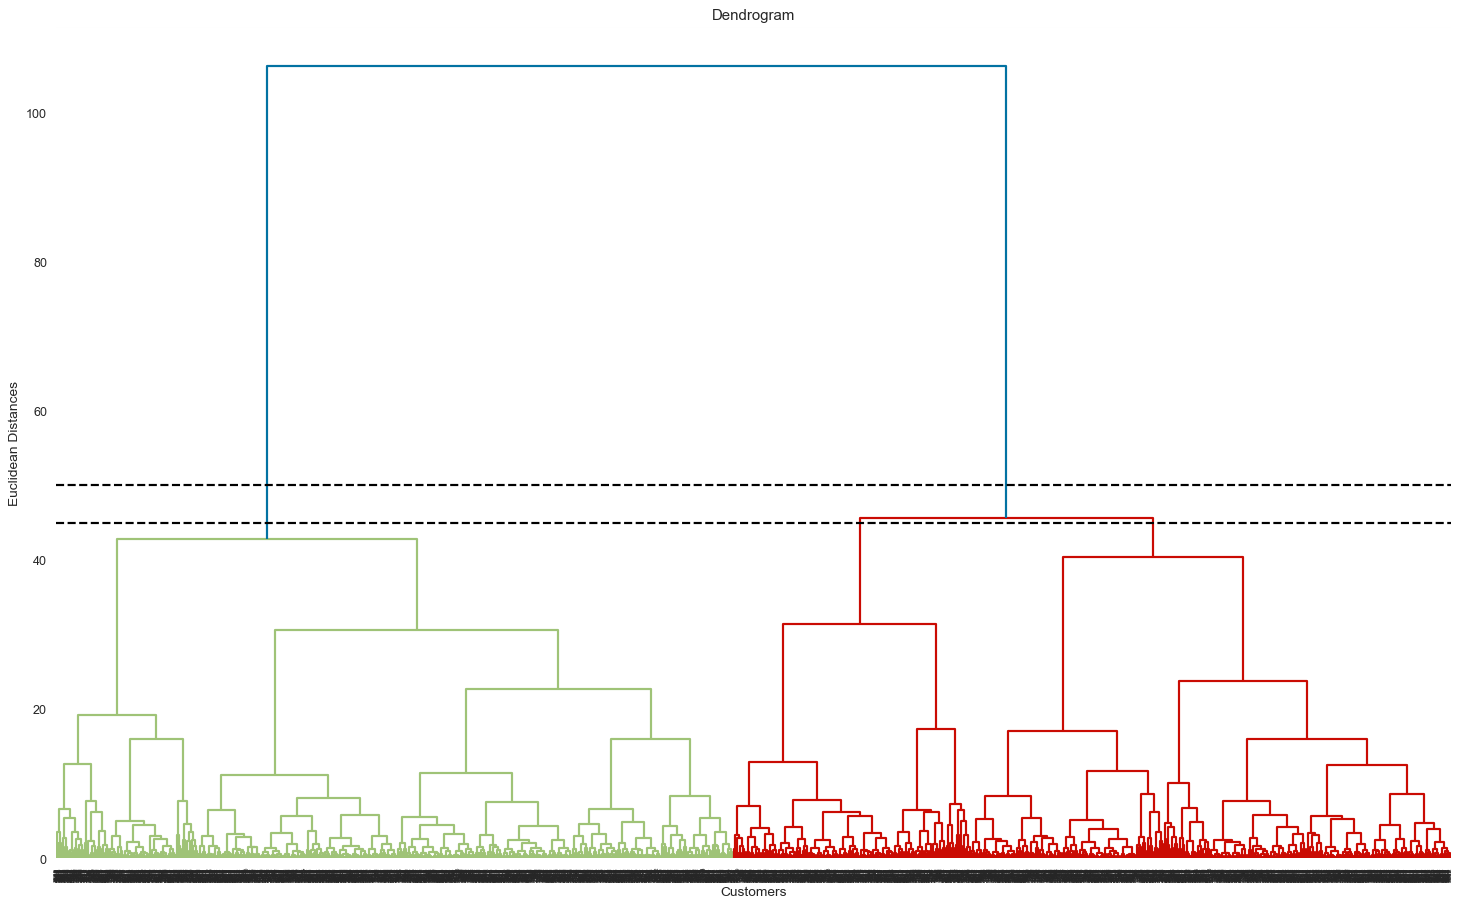

In [100]:
# Using the Dendogram to Decide the number of clusters
plt.figure(figsize=(20,12), dpi=90)                         
dendrogram(linkage(X, method='ward'), color_threshold=50)   # using ward linkage method to differ similarities
plt.title('Dendrogram')                                     
plt.xlabel('Customers')                                     
plt.ylabel('Euclidean Distances')                           
plt.axhline(y=50, color='black', linestyle='--')            
plt.axhline(y=45, color='black', linestyle='--')           
plt.show() 

Larget threshold, y = 50, gives 2 clusters while smaller, y = 45, gives 3 clusters

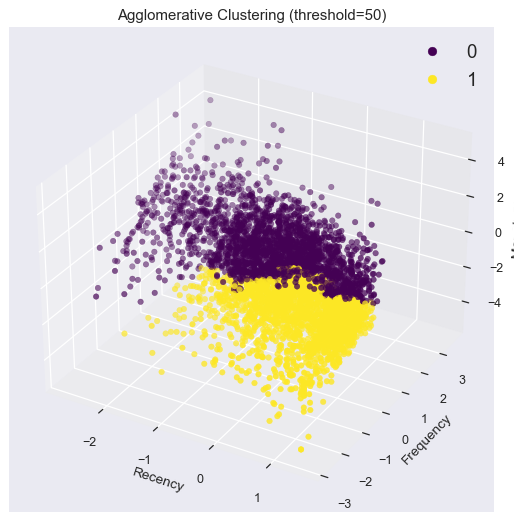

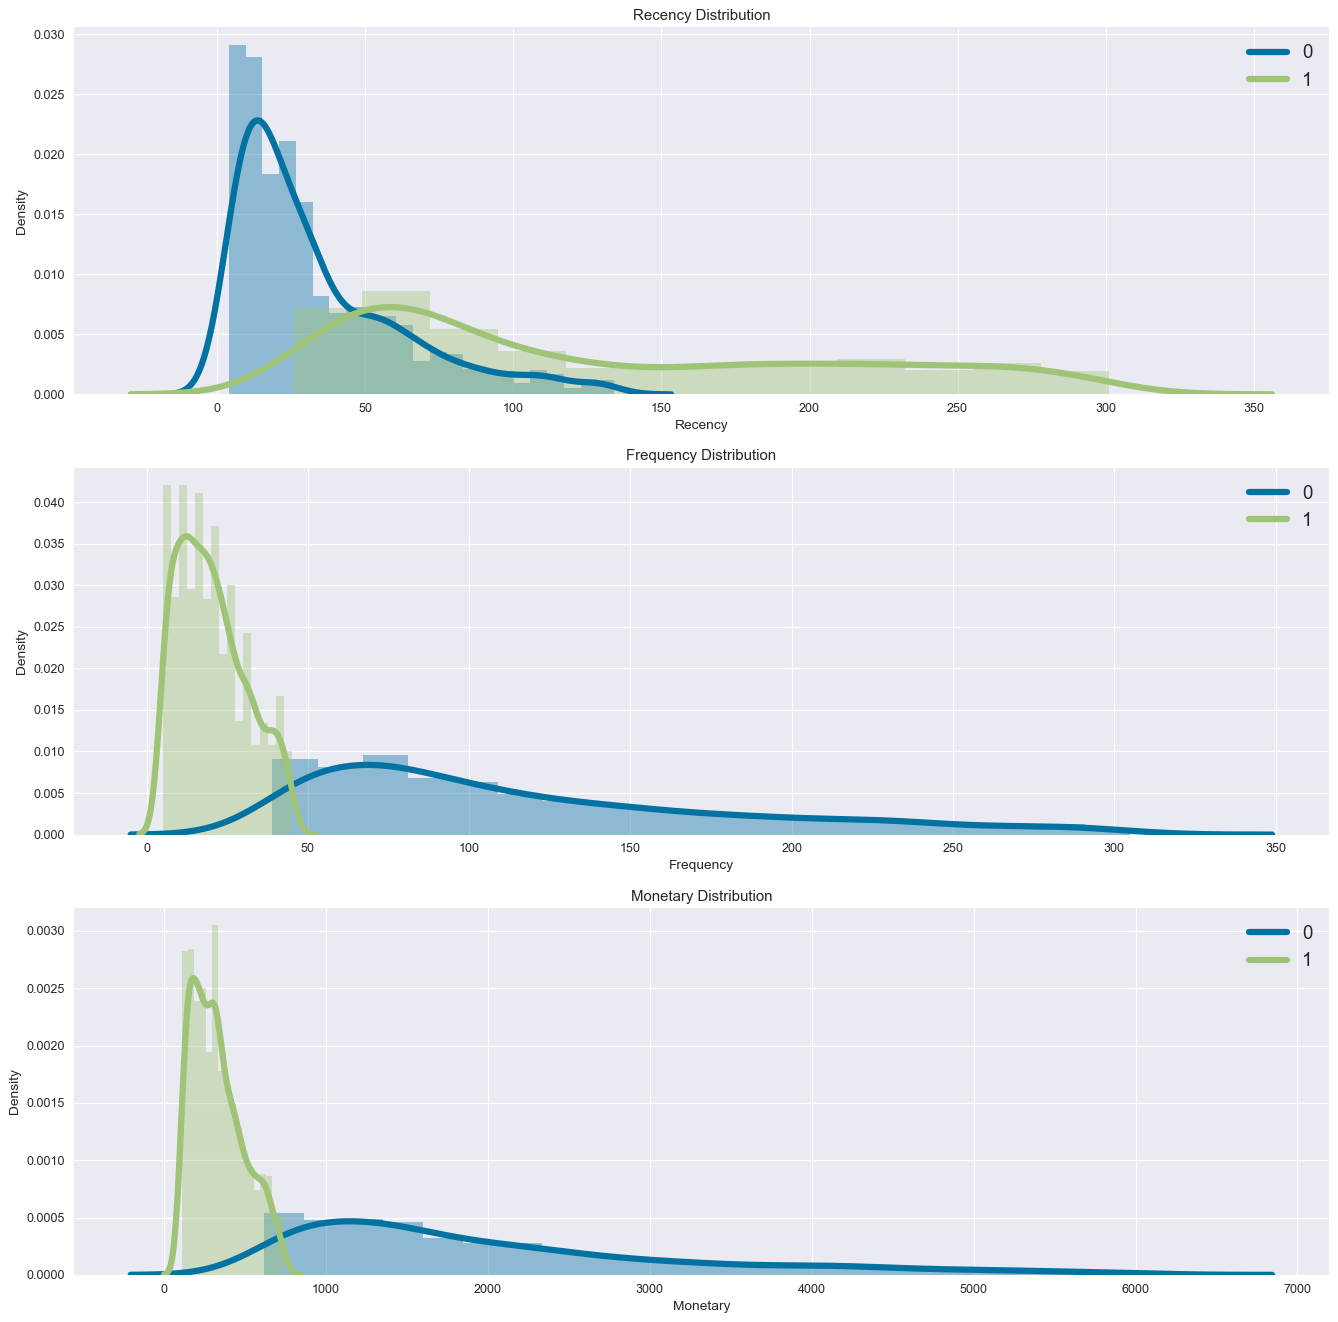



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



,hierarchical|2Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,0,47.381769,24.000000,159.851083,98.000000,3602.100565,1648.440000,2216
1,1,137.624881,99.000000,22.267398,19.000000,388.932741,305.950000,2098


,hierarchical|2Cluster,Last_visited,Purchase_frequency,Money_spent
0,0,10 to 57 days ago,Bought 59 to 178 times,Spent around 967 to 3035 Sterling
1,1,51 to 220 days ago,Bought 9 to 31 times,Spent around 174 to 485 Sterling


In [104]:
# Fitting hierarchical clustering with number of clusters based on dendogram distance threshold = 70
ahc = AgglomerativeClustering(n_clusters=2, linkage='ward')     # Initializing the model
y = ahc.fit_predict(X)                                                                # Fitting and predicting the model

# Visualizing the clusters with n_clusters = 2
title = 'Agglomerative Clustering (threshold=50)'                                     
segment_name = 'hierarchical|2Cluster'
overlap_supress = 0.1
color="gnuplot"
conclusion[segment_name] = plots_stats_summary(y, segment_name, color,title, overlap_supress)

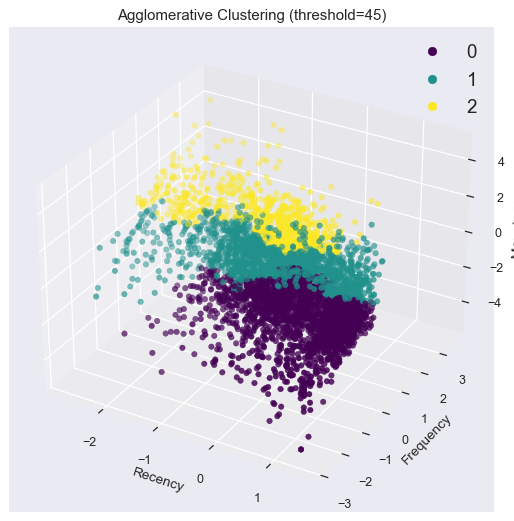

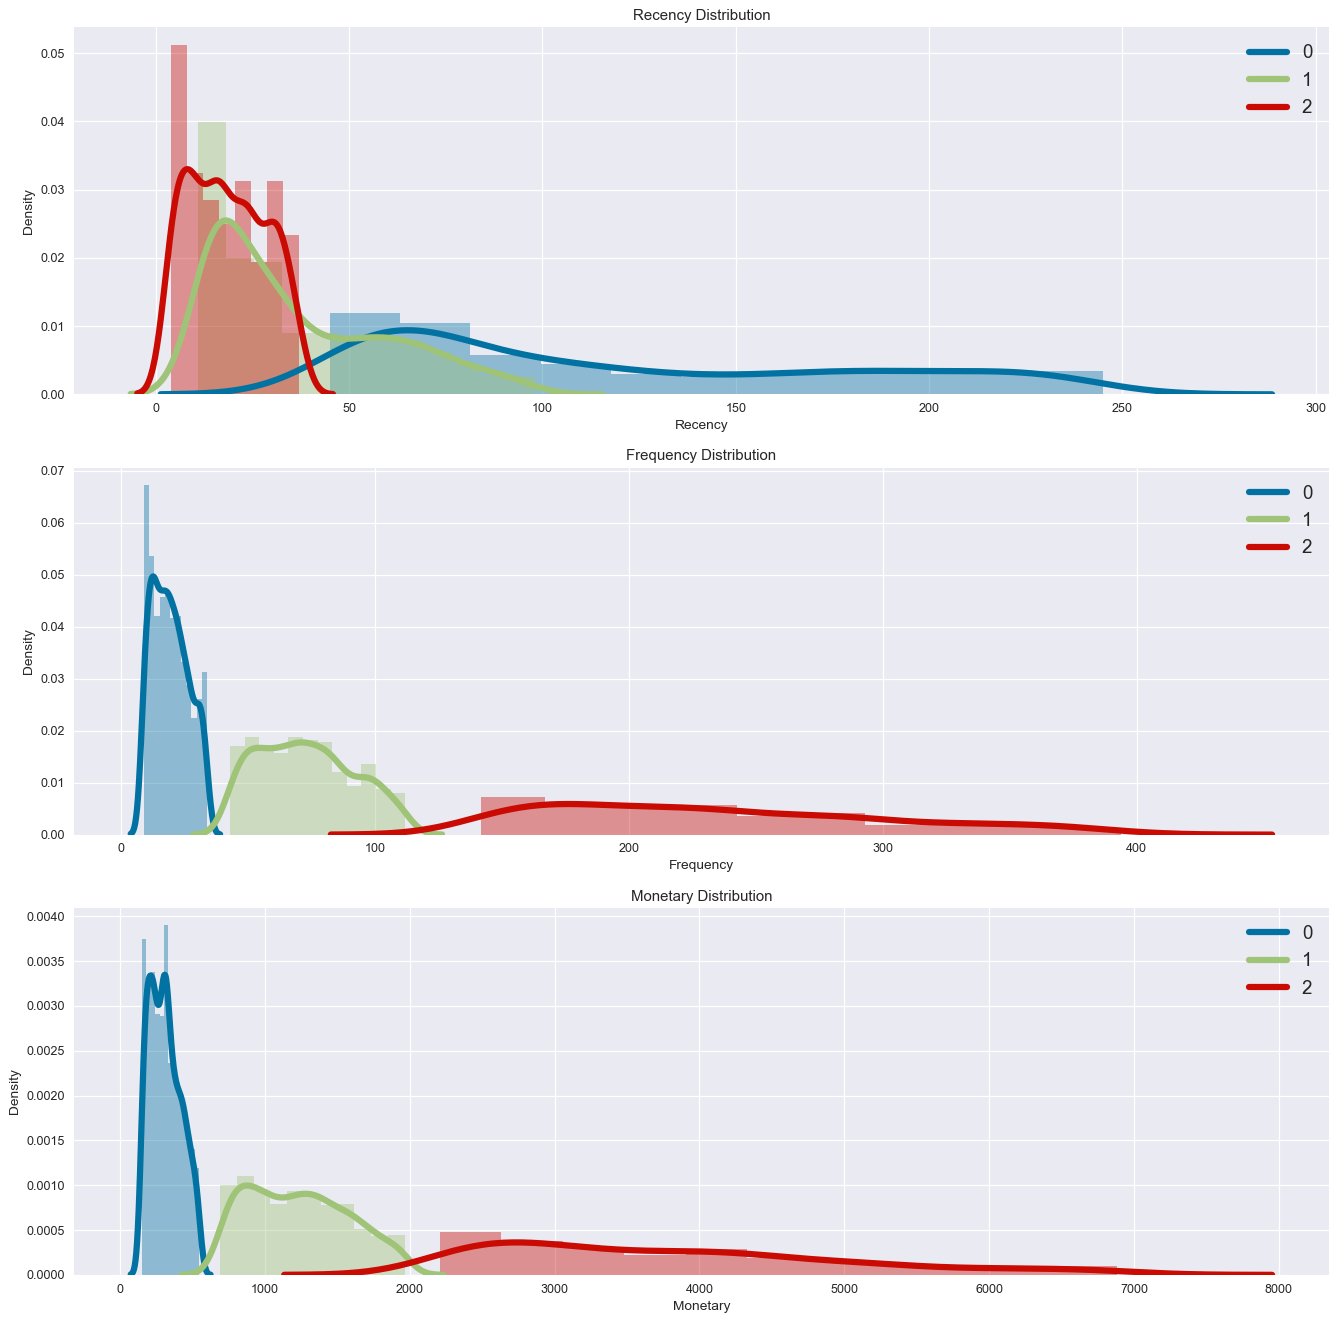



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



,hierarchical|3Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,0,137.624881,99.000000,22.267398,19.000000,388.932741,305.950000,2098
1,1,59.153535,29.000000,81.757576,72.000000,1672.551195,1220.480000,1485
2,2,23.467852,17.000000,318.495212,224.000000,7521.910163,3514.180000,731


,hierarchical|3Cluster,Last_visited,Purchase_frequency,Money_spent
0,0,51 to 220 days ago,Bought 9 to 31 times,Spent around 174 to 485 Sterling
1,1,12 to 74 days ago,Bought 48 to 102 times,Spent around 768 to 1766 Sterling
2,2,4 to 33 days ago,Bought 152 to 346 times,Spent around 2370 to 5847 Sterling


In [105]:
# Fitting hierarchical clustering with number of clusters based on dendogram distance threshold = 50
ahc = AgglomerativeClustering(n_clusters=3, linkage='ward')     # Initializing the model
y = ahc.fit_predict(X)                                                                

# Visualizing the clusters with n_clusters = 3
title = 'Agglomerative Clustering (threshold=45)'                                    
segment_name = 'hierarchical|3Cluster'
overlap_supress = 0.2
color="rainbow"
conclusion[segment_name] = plots_stats_summary(y, segment_name, color,title, overlap_supress)
     

## E. DBSCAN Clustering

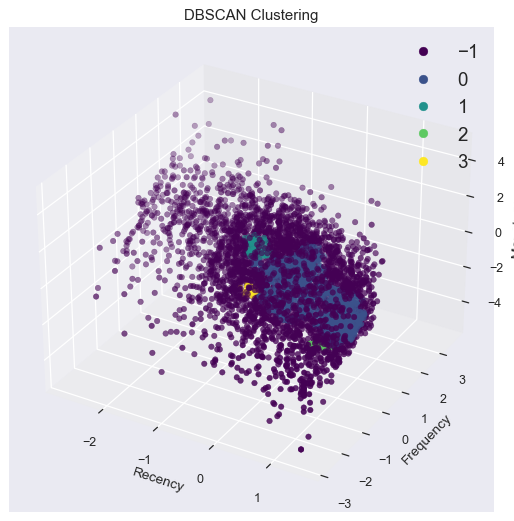

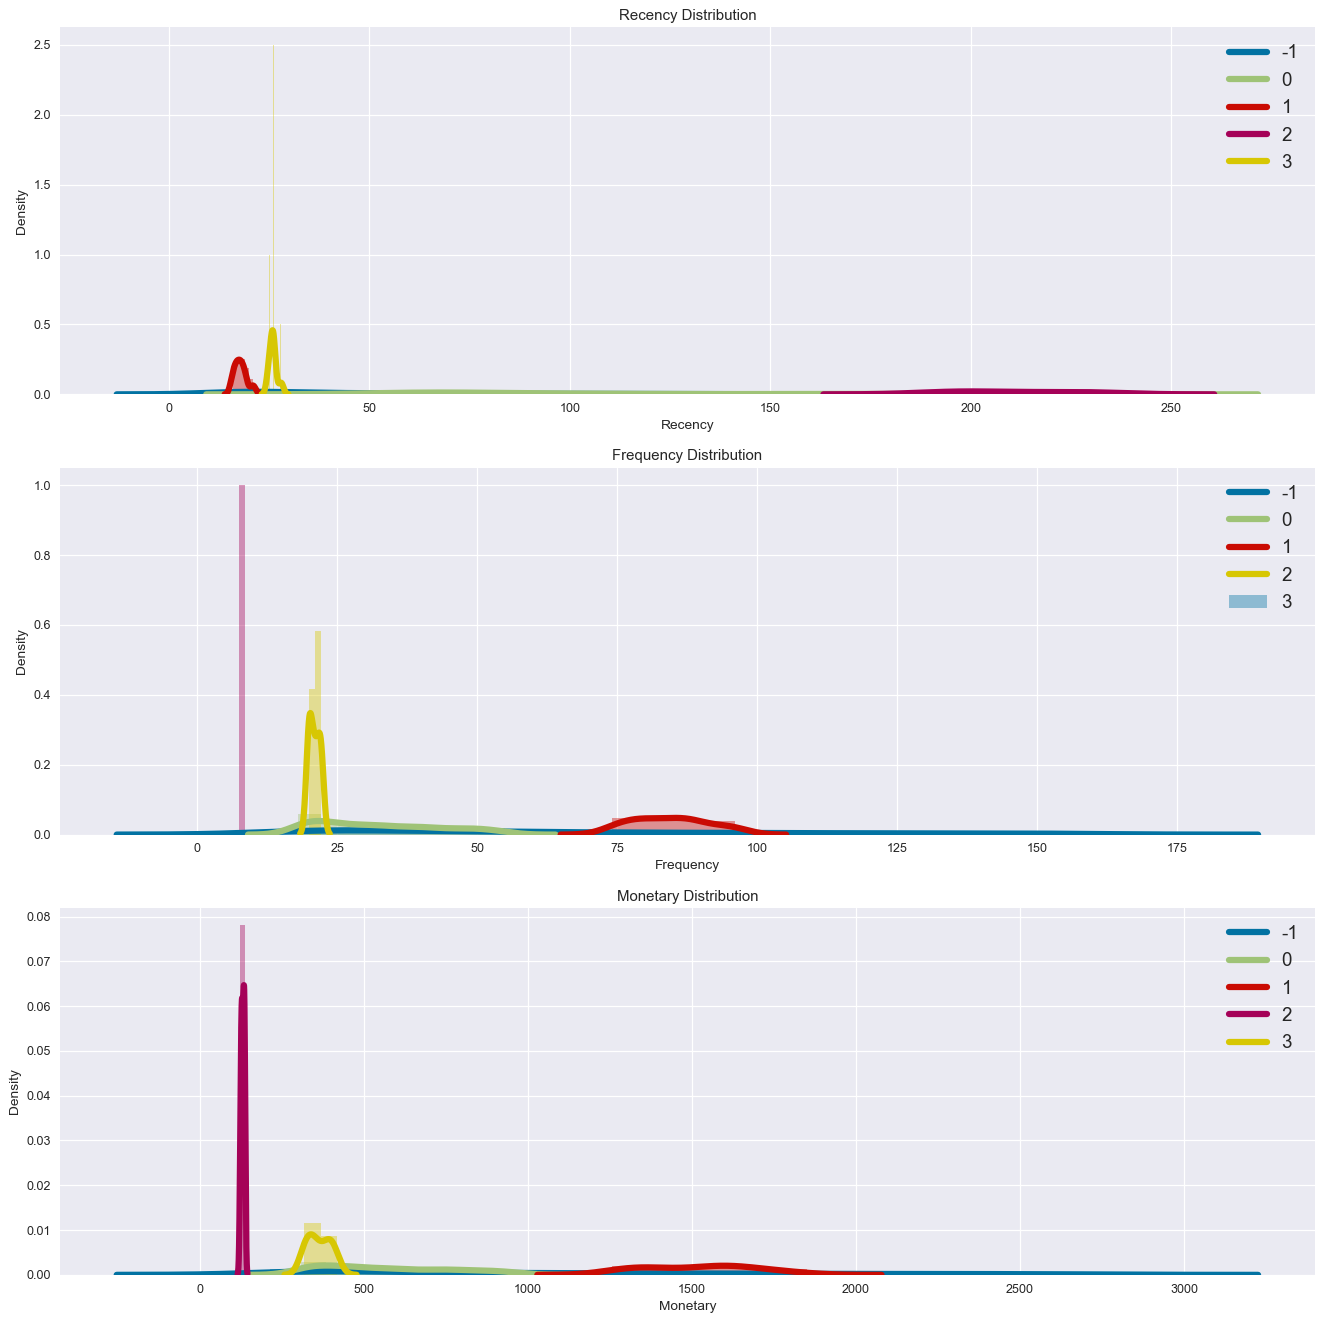



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



,DBSCAN,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,-1,79.632372,36.000000,112.891026,53.000000,2535.336654,827.560000,3120
1,0,130.275959,82.000000,38.371375,31.000000,697.984510,541.140000,1069
2,1,18.373494,18.000000,85.060241,84.000000,1574.467614,1563.030000,83
3,2,214.666667,209.000000,8.055556,8.000000,131.291667,130.040000,18
4,3,26.166667,26.000000,20.958333,21.000000,366.495000,356.755000,24


,DBSCAN,Last_visited,Purchase_frequency,Money_spent
0,-1,14 to 115 days ago,Bought 17 to 134 times,Spent around 277 to 2255 Sterling
1,0,57 to 201 days ago,Bought 19 to 50 times,Spent around 327 to 884 Sterling
2,1,16 to 21 days ago,Bought 75 to 95 times,Spent around 1287 to 1753 Sterling
3,2,193 to 231 days ago,Bought 7 to 9 times,Spent around 123 to 135 Sterling
4,3,24 to 29 days ago,Bought 19 to 22 times,Spent around 320 to 405 Sterling


In [106]:
# Fitting DBSCAN clusterer
dbsc = DBSCAN(eps=0.2, min_samples=25)                                
y = dbsc.fit_predict(X)                                               

# Plotting Clusters for Visualization
title = 'DBSCAN Clustering'                                           
segment_name = 'DBSCAN'
overlap_supress = 0.2
color="YlGnBu"
conclusion[segment_name] = plots_stats_summary(y, segment_name, color,title, overlap_supress)

In [108]:
summary = pd.DataFrame({"Clusterer": ['Binning','Quantile Cut', "K-Means", "K-Means", "K-Means", "Agglomerative","Agglomerative", "DBSCAN"],
                        'Criterion': ['RFM Score Binning', 'RFM Quantile Cut', 'Elbow Curve', 'Silhouette Score','Elbow Curve & Silhouette Score',
                                      'Dendogram (y=50)', 'Dendogram (y=45)', 'eps=0.2, min_samples=25'],
                        "Segments" : [4,4,5,2,4,2,3,4]},
                        index=['', '', '', '', '', '', '', ''])
summary.T 

,,,,,,,,
Clusterer,Binning,Quantile Cut,K-Means,K-Means,K-Means,Agglomerative,Agglomerative,DBSCAN
Criterion,RFM Score Binning,RFM Quantile Cut,Elbow Curve,Silhouette Score,Elbow Curve & Silhouette Score,Dendogram (y=50),Dendogram (y=45),"eps=0.2, min_samples=25"
Segments,4,4,5,2,4,2,3,4


## Conclusion

1. Simple binning and Quantile based simple segmentation model for clustering is studied first

2. Analyzed data using complex clustering techniques like K-Means, Hierarchical and DBSCAN clusterer as well. 

3. Though significantly seperated clusters are not visible in the plots, but these clusters are fairly valid as per the algorithms and statistics extracted by the formation of clusters